## Imports

In [150]:
############
# Built-in #
############
import ast
from itertools import groupby
import os
import re
import tempfile

###############
# Third-party #
###############
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

## Database Connection Setup

In [3]:
HOST = 'localhost'
USER = 'db_user'
PORT = 5438
DATABASE = 'msd_db'
PASSWORD = 'LetMeIn'
TABLE_NAME = 'song_info'

# Connect with SQLAlchemy
conn_string = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'
sqla_conn = create_engine(conn_string)

## Notebook Functions
Functions that are used throughout this notebook to either help load data or process data.

In [5]:
def read_sql_with_copy(query, db_engine, convert_list_cols=False):
    '''Run a SQL query using the COPY command to reduce RAM usage.
    
    By using a temporary file to run a query, this cuts down on the
    memory usage by utilizing a direct download to CSV rather than 
    dealing with all the overhead that pandas does internally with 
    its built-in `read_sql` function.
    
    Parameters
    ----------
    query : str
        Query string to pass into the database
        
    db_engine : SQLAlchemy engine object
        SQLAlchemy engine for creating connections
        
    convert_list_cols : bool
        If `True`, this will convert any columns that are supposed to be
        lists into actual lists instead of the strings that this method
        returns for those columns.
    '''
    print('Running query...', end = '')
    try:
        with tempfile.TemporaryFile() as tmp:
            copy_sql = f'COPY ({query}) TO STDOUT WITH CSV HEADER'
            conn = db_engine.raw_connection()
            cur = conn.cursor()
            cur.copy_expert(copy_sql, tmp)
            tmp.seek(0)
            df = pd.read_csv(tmp)
    except Exception as e:
        print(e)
    finally:
        cur.close()
        conn.close()
    print('done!')
    
    if convert_list_cols:
        # Get columns that are supposed to be lists
        print('Converting list columns...', end = '')
        list_cols = []
        for col in df.columns:
            try:
                # There is a song containing curly braces in the title so
                # this will pick up on that, hence the extra conditioning
                # on the 'title' column
                if any(df[col].str.contains('{')) and col != 'title': 
                    list_cols.append(col)
            except:
                # If a column doesn't have a `str` attribute, it is not a string
                # column so it should error out above and we can ignore that column
                continue

        # Change curly braces to brackets and change to list
        # using some funky regex here to properly wrap text
        # in double quotes so `ast.literal_eval` works, i.e.,
        # turns '{item_1, item_2, ...}' into '["item_1", "item_2", ...]'
        # so literal evaluation turns it into an actual list
        pattern = re.compile(r'{([\w\s,\-"&]+)}')
        f_inner = lambda x: '{{{}}}'.format(re.sub(r'[\w\s\-&]+', r'"\g<0>"', x.group(1)))
        f_outer = lambda x: ast.literal_eval(
            re.sub(pattern, f_inner, x.replace('"', '')).replace('{', '[').replace('}', ']')
        )
        for col in list_cols:
            df[col] = df[col].apply(f_outer)
        print('done!')
    
    return df

In [7]:
def plot_artist_terms(df):
    '''Plot artist terms by year.
    
    This is a custom plotting function taken and adapted from
    https://stackoverflow.com/questions/58854335/how-to-label-y-ticklabels-as-group-category-in-seaborn-clustermap.
    
    Parameters
    ----------
    df : pandas DataFrame
        DataFrame with artist term data to plot.
    '''
    def _add_line(ax, xpos, ypos):
        '''Helper function to add lines to split up groups.'''
        line = plt.Line2D(
            [xpos, xpos], 
            [ypos + .1, ypos],
            transform = ax.transAxes, 
            color = 'black'
        )
        line.set_clip_on(False);
        ax.add_line(line);
        
    def _label_len(index, level):
        '''Helper function to get the length of labels in each level.'''
        labels = index.get_level_values(level)
        return [(k, sum(1 for i in g)) for k, g in groupby(labels)]
    
    def _label_group_bar_table(ax, df):
        '''Helper function to properly position and add labels to graph.'''
        ypos = -.1
        scale = 1.0 / df.index.size
        for level in range(df.index.nlevels)[::-1]:
            pos = 0
            
            # We need to iterate through each index/group that we want
            # to graph and then adjust the y-axis position so it doesn't
            # overlap with the graph bars
            for label, rpos in _label_len(df.index, level):
                lxpos = (pos + .5 * rpos) * scale
                if level == 1: # This affects only the `artist_term` column
                    ypos_label = -len(label) * 0.01
                    rotation = 90
                else:
                    ypos_label = ypos
                    rotation = 0
                    
                ax.text(
                    lxpos, 
                    ypos_label, 
                    label, 
                    ha = 'center',
                    transform = ax.transAxes, 
                    rotation = rotation
                );
                _add_line(ax, pos * scale, ypos)
                pos += rpos
            _add_line(ax, pos * scale , ypos)
            ypos -= .1
    
    # Re-index input DataFrame so we can properly iterate through
    # the indices and plot them on the graph
    tuples = list(zip(df['year'], df['artist_term']))
    index = pd.MultiIndex.from_tuples(tuples, names = ['year', 'artist_term'])
    min_year = df['year'].min()
    max_year = df['year'].max()
    df = df.set_index(index)[['artist_term_count']]
    
    fig = plt.figure(figsize = (15, 10))
    ax = fig.add_subplot(111)
    df.plot(kind = 'bar', ax = fig.gca());
    
    # Re-label axes with new labels
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels);
    ax.set_xlabel('');
    ax.set_ylabel('Count');
    ax.set_title(f'Top 3 Artist Terms by Year ({min_year} - {max_year})');
    _label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom = .1 * df.index.nlevels);

## Data Loading
Doing a straight `read_sql` with pandas uses a lot of overhead with the size of our dataset, so we have to use a memory workaround with our custom `read_sql_with_copy` function.

In [8]:
# Example usage of how to get data into
# a DataFrame with the `read_sql_with_copy` function
query = f'''
    SELECT 
        *
    FROM {TABLE_NAME}
    LIMIT 10
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
query_df.head()

Running query...done!


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
0,TRBGJCT128F933A606,SOBBQDL12A58A7A988,100 Club 1996 ''We Love You Beatles'' - Live,5195440,22050,40f155321c40015d95c7815033a54e15,0,88.73751,0.298,0,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{{0.97,1.0,0.502,0.362,0.352,0.377,0.356,0.259...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{punk,italy,""british punk rock"",soundtrack,""pr...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...","{ARNTVM11187B98B4B4,AREKBBQ11F50C4971D,ARNFTGS...",414,0.731184,0.549204,ARD3LXU1187B9ABFC5,NaN,NaN,NaN,e5db18cb-4b1f-496d-a308-548b611090d3,Sex Pistols,1418,NaN,Sex Pistols - The Interviews,467088,NaN,"{british,""punk rock"",uk,london,england,english...","{4,3,3,1,1,1,1,1,1,1}",0
1,TRBGJOG12903CC3E93,SOIZHEV12A8C14138B,Yo Quiero Contigo,7948828,22050,88ff14072530c24e4a71dc36d8cfcd4d,0,167.36608,5.851,0,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{{0.828,0.564,0.238,0.302,1.0,0.8,0.808,0.586,...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{{27.46,-55.217,73.516,-97.74,29.328,151.265,7...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{reggaeton,""los angeles"",california,""hip hop"",...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...","{AROTGDJ12454A52E29,ARYFNBU12454A4D74D,ARROGBH...",170931,0.610186,0.355320,ARWWPKQ11F4C83D8E2,NaN,NaN,NaN,NaN,Baby Rasta & Gringo,-1,NaN,Sentenciados - Platinum Edition,716669,NaN,{},{},0
2,TRBGJFN128F429AB79,SOHFGYR12A8C13AE07,Vankina vapauden,1170609,22050,77ab2a1f981525fea9c68f3b6958e402,0,189.36118,5.515,0,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-

## Data Analysis
How have song characteristics changed over time? 

In [9]:
# Get only the songs that have a valid `year` value
query = f'''
    SELECT 
        *
    FROM {TABLE_NAME}
    WHERE year != 0
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
print(query_df.shape)
query_df.head()

Running query...done!
(4680, 55)


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
0,TRBGJZN12903D0D2FC,SOKMTOP12AC468980A,Emerald,7761766,22050,6b64c74c1595a7f840e1725062ac56ec,0,501.86404,0.000,0,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,"{0.957,0.716,0.281,0.146,0.093,0.202,0.1,0.564...","{0.89503,2.74044,4.58714,6.43382,8.27926,10.12...","{1.0,1.0,1.0,0.958,0.615,0.605,0.514,0.962,1.0...","{0.43242,0.89503,1.35628,1.81753,2.27956,2.740...","{1.0,0.168,0.337,0.446,1.0,1.0,1.0,0.241,0.066...","{0.0,14.2806,45.20694,80.74071,162.8994,177.66...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{-29.298,-28.07,-14.076,-27.513,-14.988,-27.72...","{0.20317,0.00926,0.02198,0.02842,0.02253,0.010...","{-60.0,-51.502,-59.719,-51.718,-46.497,-51.434...","{{1.0,0.94,0.717,0.57,0.512,0.396,0.108,0.23,0...","{0.0,0.20354,0.42091,0.6449,0.87964,1.12562,1....","{{10.432,-47.756,-229.034,-108.474,-31.688,-16...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{0.20169,0.43242,0.6643,0.89503,1.12565,1.3562...","{""progressive house"",""progressive trance"",""tec...","{1.0,0.9862037285015448,0.8886521610598996,0.9...","{1.0,0.9696513385348325,0.9168794583576614,0.9...","{ARSS3WR1187B98EE9F,ARCYE581187B9A1482,AROZNFA...",304705,0.654039,0.390625,ARFN4JN1187B98C627,-22.96566,18.48617,Detroit,3c34ad84-7628-459e-949d-c27e2ae73231,Bedrock,-1,NaN,Emerald,699533,NaN,{},{},2004
1,TRBGJDW128F4292EDB,SODHTCY12A58A7F125,Karma,3358987,22050,cd8980dbf1346e4a9d24dd815670091b,0,255.99955,0.177,0,7,0.267,-6.155,0,0.324,253.498,113.485,3,1.000,"{0.09,0.136,0.29,0.06,0.26,0.22,0.176,0.113,0....","{1.08556,2.67647,4.26478,5.85043,7.43605,9.023...","{0.309,0.349,0.379,0.548,0.494,0.303,0.651,0.2...","{0.55496,1.08556,1.61615,2.14411,2.67647,3.207...","{1.0,0.82,0.22,0.419,0.453,0.186,0.496,0.278,0...","{0.0,22.23993,48.67053,71.40721,91.51556,113.6...","{0.0,1.0,0.994,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0...","{-60.0,-9.78,-11.368,-13.466,-3.287,-12.824,-1...","{0.0,0.02244,0.01367,0.02897,0.02849,0.069,0.0...","{-60.0,-60.0,-26.73,-28.15,-21.195,-36.534,-33...","{{0.565,0.709,0.578,0.611,0.555,1.0,0.951,0.47...","{0.0,0.1771,0.53528,0.69374,0.88567,1.19252,1....","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{1.0,0.991,0.973,0.958,0.942,0.924,0.92,0.906,...","{0.20093,0.37751,0.55496,0.73153,0.9081,1.0855...","{""neo soul"",blues,soul,pop,urban,""new york"",ba...","{0.9999845940096209,1.0,0.8910057640374122,0.9...","{1.0,0.8806308968212047,0.791299665206063,0.75...","{AR5DC8S1187B9958BE,ARVP1TO1187B9A4A7A,AR24DZB...",1237,0.933916,0.778674,AR52EZT1187B9900BF,40.80790,-73.94540,"Harlem, New York",8ef1df30-ae4f-4dbd-9351-1a32b208a01e,Alicia Keys,66,NaN,The Diary Of Alicia Keys,296589,0.723349,"{rnb,""neo soul"",soul,""hip hop rnb and dance ha...","{2,1,1,1,1,1,1,1}",2003
2,TRBGJIZ128F92E42BC,SOQBAQW12AAF3B35B8,Heartbreaker,104485,22050,fc6ea9b86321f00a1a8dc68dad4789f4,0,229.56363,0.202,0,2,0.500,-11.680,1,0.484,224.467,165.904,4,0.000,"{0.196,0.058,0.04,0.008,0.102,0.041,0.011,0.12...","{0.59147,2.03856,3.48554,4.93127,6.37563,7.822...","{1.0,0.634,0.531,0.481,0.71,0.78,0.901,0.931,1...","{0.22898,0.59147,0.95215,1.31453,1.67691,2.038...","{1.0,0.852,0.151,0.119,1.0,0.978,0.513,0.617,0...","{0.0,19.39571,44.35586,77.27201,98.63158,110.5...","

In [7]:
query_df.describe(include = 'all')

,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
count,4680,4680,4680,4.680000e+03,4680.0,4680,4680.0,4680.000000,4680.000000,4680.0,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680.000000,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680,4680.000000,4680.000000,4680.000000,4680,1825.000000,1825.000000,3062,4662,4680,4680.000000,0.0,4680,4680.000000,3064.000000,4680,4680,4680.000000
unique,4680,4680,4561,NaN,NaN,4679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4665,4665,4667,4668,4668,4670,4679,4679,4679,4679,4679,4679,4679,4672,4672,2092,2091,2091,2129,NaN,NaN,NaN,2092,NaN,NaN,745,2081,2238,NaN,NaN,3762,NaN,NaN,589,107,NaN
top,TRBGJZN12903D0D2FC,SOKMTOP12AC468980A,Intro,NaN,NaN,b1b14821ff71f009742cddcbc4b6c997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},{},{},{},{},{},"{0.0,1.0,0.747,0.704,0.806,0.797,0.842,0.786,1...","{-60.0,-19.026,-20.802,-22.856,-21.578,-22.27,...","{0.0,0.10086,0.11744,0.02553,0.01596,0.0205,0....","{-60.0,-60.0,-30.337,-32.179,-30.81,-27.192,-2...","{{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...","{0.0,0.06095,0.28113,0.61737,0.85533,1.07732,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...",{},{},"{""hip hop"",""old school hip hop"",""east coast ra...","{1.0,0.740742819928794,0.7405196525268553,0.86...","{1.0,0.8863975653467969,0.886197227828683,0.87...","{ARKAI6D1187B98A539,ARNHMFD1187FB3B3F6,ARBJXCS...",NaN,NaN,NaN,ARX9YIP1187B98A656,NaN,NaN,"Los Angeles, CA",5ecc3f72-20a6-47a0-8dc5-fb0b3dadeea0,Aerosmith,NaN,NaN,Greatest Hits,NaN,NaN,{},{},NaN
freq,1,1,11,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15,12,12,10,10,2,2,2,2,2,2,2,8,8,12,12,12,12,NaN,NaN,NaN,12,NaN,NaN,102,12,11,NaN,NaN,15,NaN,NaN,2118,2118,NaN
mean,NaN,NaN,NaN,3.765112e+06,22050.0,NaN,0.0,238.781146,0.800279,0.0,5.272222,0.451835,-9.683453,0.684615,0.478741,230.169829,125.163716,3.586111,0.510216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81356.039530,0.631585,0.441711,NaN,37.501760,-61.772744,NaN,NaN,NaN,22032.868376,NaN,NaN,338235.098291,0.444377,NaN,NaN,1997.232051
std,NaN,NaN,NaN,2.576493e+06,0.0,NaN,0.0,101.345438,1.944104,0.0,3.547714,0.275340,5.135927,0.464719,0.187844,99.678488,35.272251,1.240247,0.375063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121019.537639,0.140808,0.128043,NaN,16.273911,51.525675,NaN,NaN,NaN,41224.786080,NaN,NaN,232015.694959,0.222470,NaN,NaN,11.686691
min,NaN,NaN,NaN,1.182000e+03,22050.0,NaN,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,1.044000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,0.000000,0.000000,NaN,-41.280540,-155.434140,NaN,NaN,NaN,-1.000000,NaN,NaN,84.000000,0.000000,NaN,NaN,1926.000000
25%,NaN,NaN,NaN,1.499538e+06,22050.0,NaN,0.0,181.152200,0.000000,0.0,2.000000,0.225750,-12.163000,0.000000,0.364000,173.248500,98.698500,3.000000,0.089000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7037.000000,0.540750,0.366820,NaN,34.053490,-93.264930,NaN,NaN,NaN,-1.000000,NaN,NaN,139389.750000,0.313562,NaN,NaN,1993.000000
50%,NaN,N

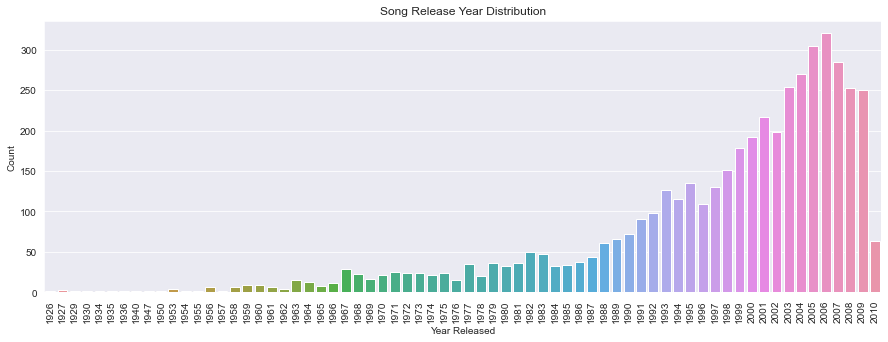

In [8]:
fig = plt.figure(figsize = (15, 5))
ax = sns.countplot(data = query_df, x = 'year')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);
ax.set_xlabel('Year Released');
ax.set_ylabel('Count');
ax.set_title('Song Release Year Distribution');

Filtering out songs with invalid years leaves us with a set of 4,680 songs - 46.80% of the original data. From the graph above, we see that we have a range of songs from 1926 to 2010, but the majority of those songs are from the 1990s and 2000s.

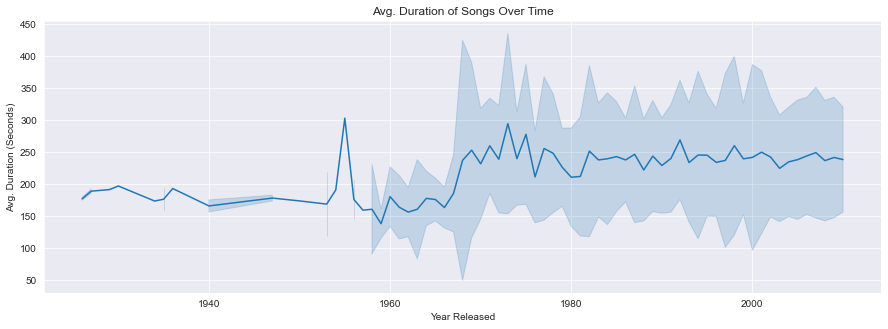

In [9]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'duration', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Duration (Seconds)');
ax.set_title('Avg. Duration of Songs Over Time');

From this graph, we see that there seems to be an increase in song duration from the late 60s to the 70s, and then duration seems to stay the same from then on.

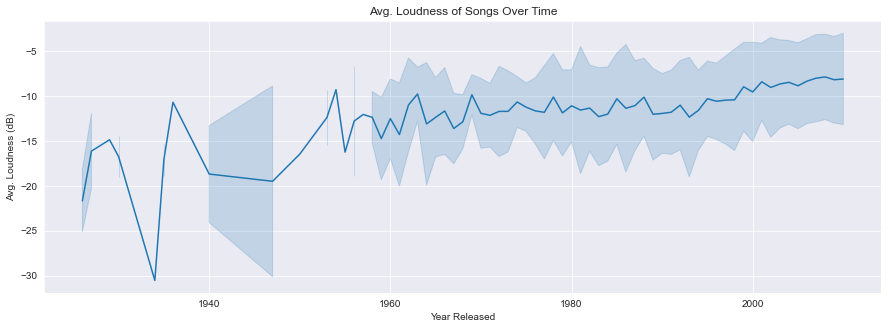

In [10]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'loudness', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Loudness (dB)');
ax.set_title('Avg. Loudness of Songs Over Time');

We see these wild fluctuations before the 60s because there aren't that many songs in the data for that time period. Once we get a good amount of song data in the 60s onwards, we see that the loudness of songs looks to go up, albeit very slightly.

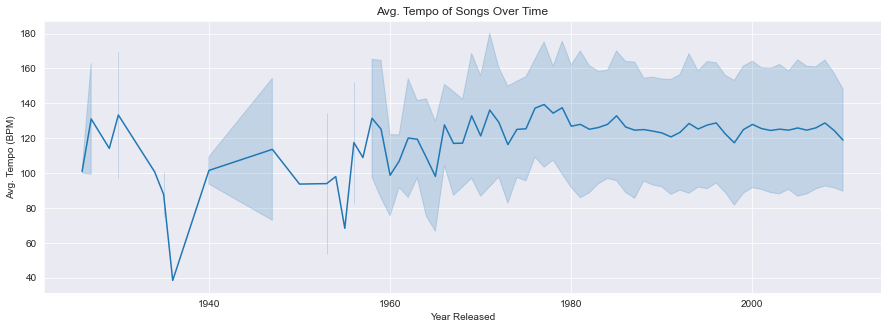

In [11]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'tempo', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Tempo (BPM)');
ax.set_title('Avg. Tempo of Songs Over Time');

Song tempo seems to stay relatively constant, save for a bump from the 60s to the 70s and onwards.

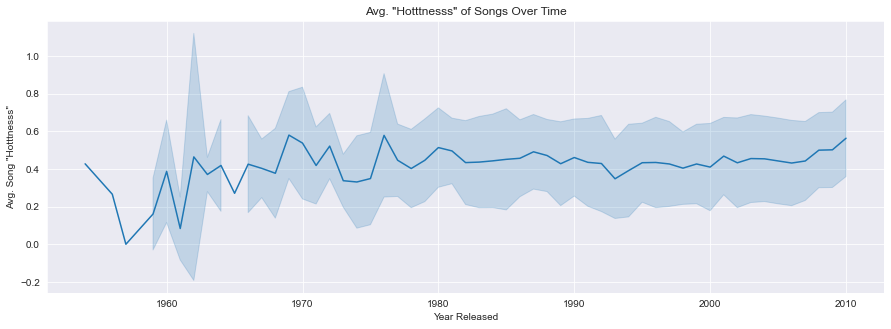

In [12]:
fig = plt.figure(figsize = (15, 5))
ax = sns.lineplot(data = query_df, x = 'year', y = 'song_hotttnesss', ci = 'sd')
ax.set_xlabel('Year Released');
ax.set_ylabel('Avg. Song "Hotttnesss"');
ax.set_title('Avg. "Hotttnesss" of Songs Over Time');

When it comes to song "hotttnesss," this value looks to stay relatively constant until the late 2000s where we see it starting to increase.

In [13]:
# Get the top 3 artist terms per year and their counts.
# If there are ties, they are ordered alphabetically.
query = f'''
    WITH grouped_year_artist_term_table AS (
        SELECT
            year,
            TRIM(artist_term) AS artist_term,
            COUNT(*) AS artist_term_count,
            ROW_NUMBER() OVER (
                PARTITION BY year ORDER BY COUNT(*) DESC, artist_term ASC
            ) AS ordered_count
        FROM {TABLE_NAME},
            UNNEST(artist_terms) AS artist_term
        WHERE year != 0
        GROUP BY year, artist_term
    )
    SELECT 
        year, 
        artist_term, 
        artist_term_count 
    FROM grouped_year_artist_term_table
    WHERE ordered_count <= 3
 '''

query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
print(query_df.shape)
query_df.head()

Running query...done!
(204, 3)


,year,artist_term,artist_term_count
0,1926,acoustic,2
1,1926,acoustic blues,2
2,1926,acoustic guitar,2
3,1927,acoustic blues,3
4,1927,american,3


In [14]:
tracks_90s_00s = query_df[query_df['year'] >= 1990]
tracks_70s_90s = query_df[
    (query_df['year'] >= 1970) &
    (query_df['year'] < 1990)
]
tracks_50s_70s = query_df[
    (query_df['year'] >= 1950) &
    (query_df['year'] < 1970)
]
tracks_30s_50s = query_df[
    (query_df['year'] >= 1930) &
    (query_df['year'] < 1950)
]
tracks_below_30s = query_df[query_df['year'] < 1930]

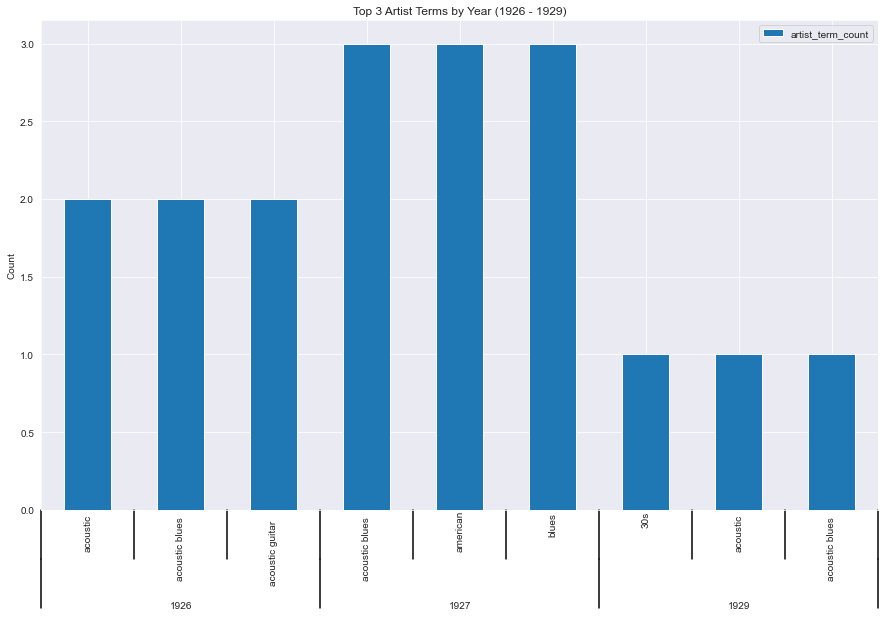

In [15]:
plot_artist_terms(tracks_below_30s)

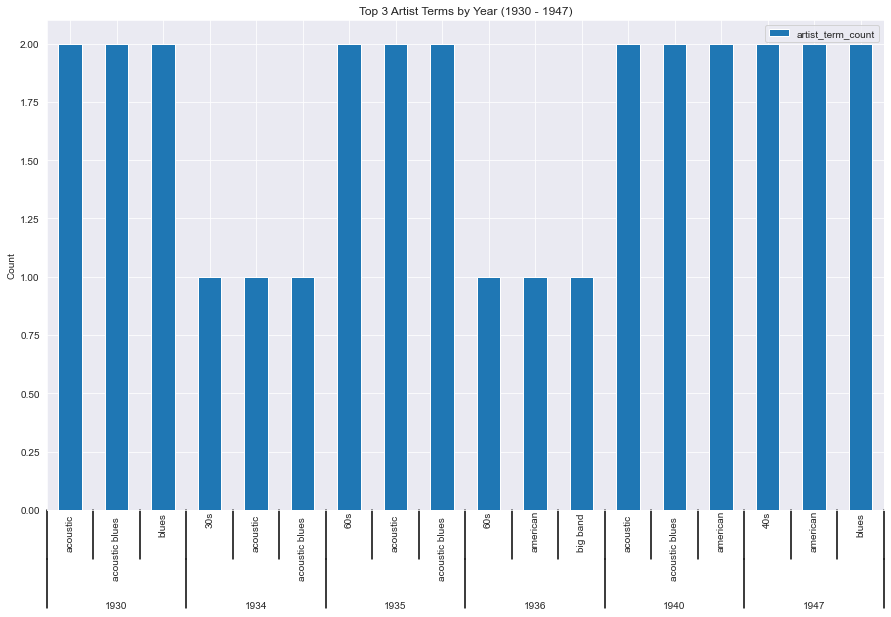

In [16]:
plot_artist_terms(tracks_30s_50s)

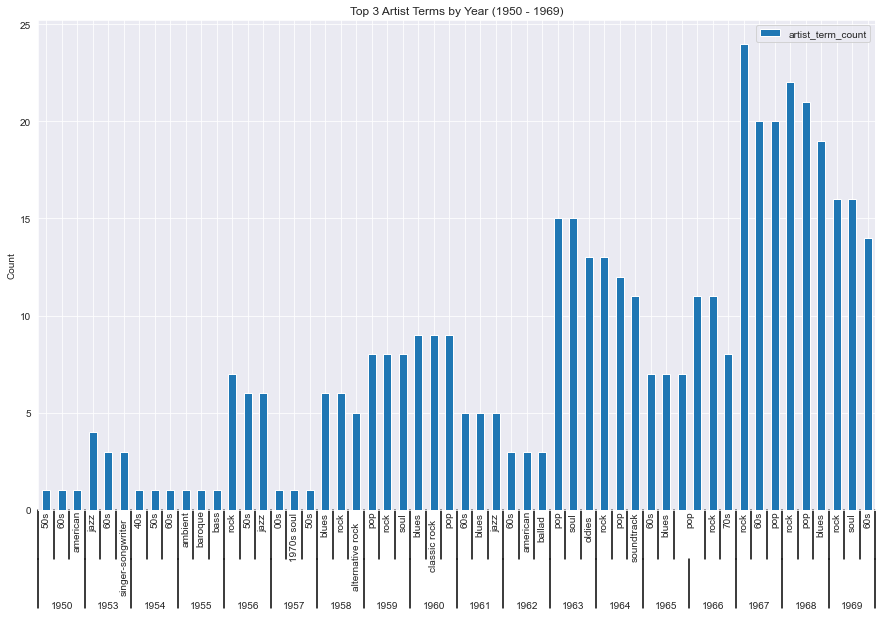

In [17]:
plot_artist_terms(tracks_50s_70s)

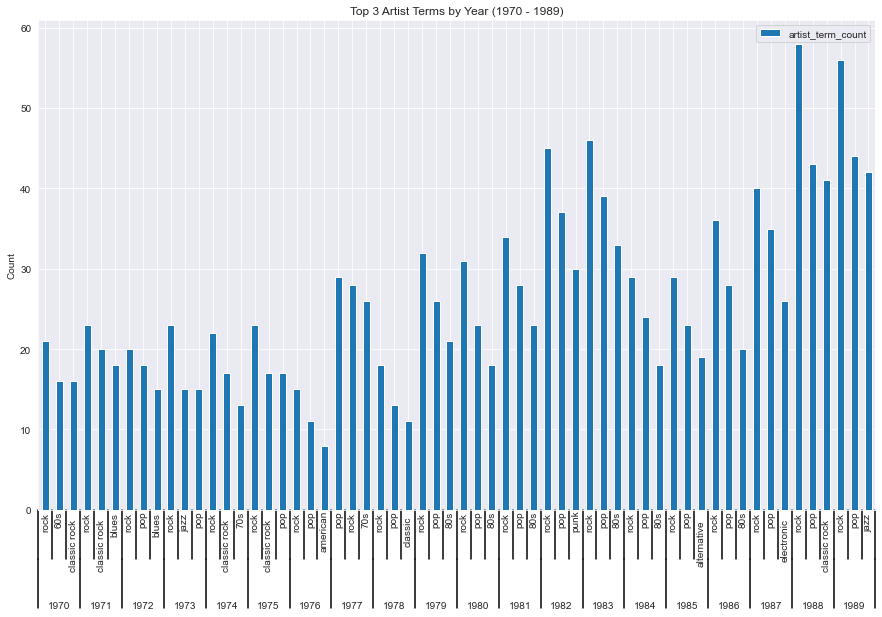

In [18]:
plot_artist_terms(tracks_70s_90s)

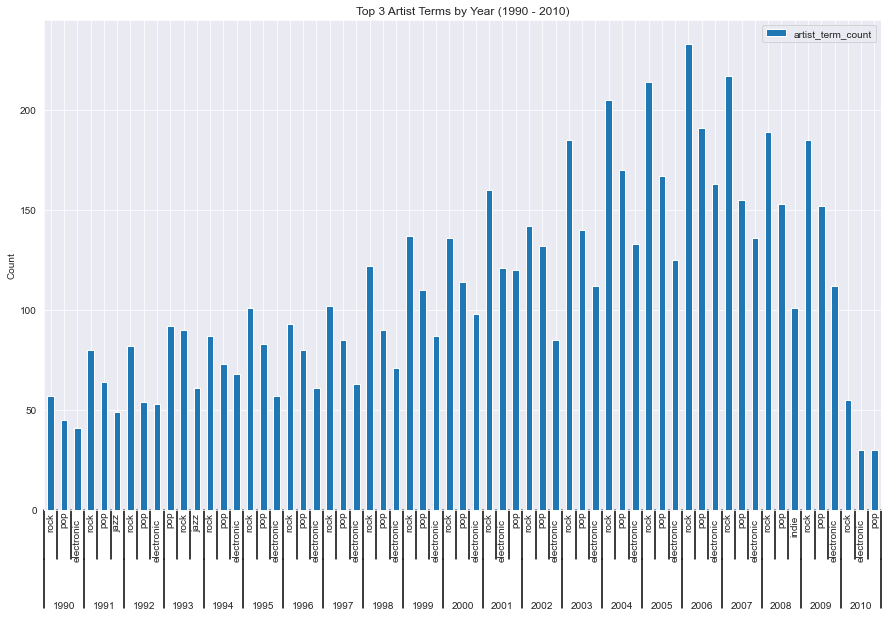

In [19]:
plot_artist_terms(tracks_90s_00s)

Text(0.5, 1.0, 'Boxplot of Sound Loudness (dB) Grouped by Year')

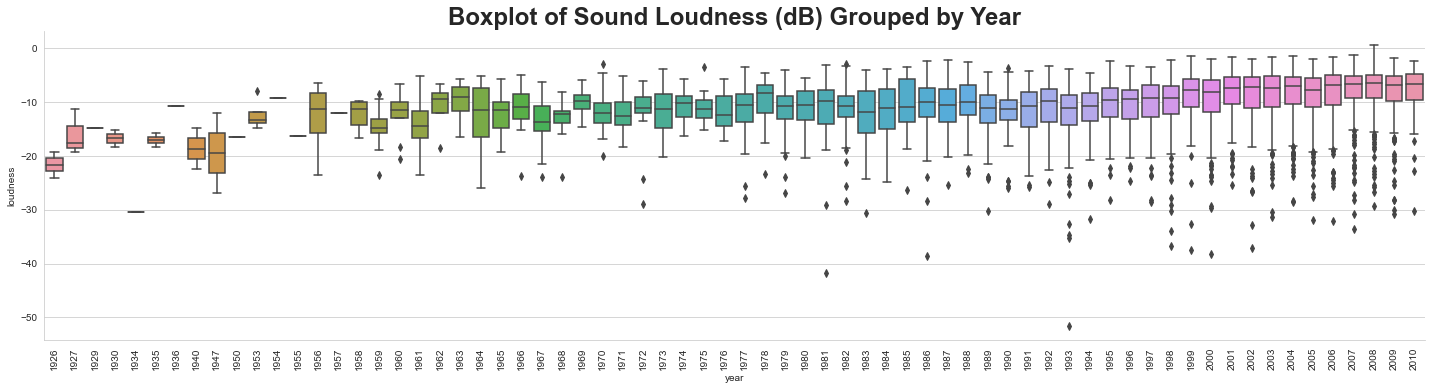

In [24]:
# boxplot of sound loudness by year
sns.set_style('whitegrid')
ax = sns.catplot(kind = 'box', x = 'year', y = 'loudness', data = query_df, aspect = 4, height = 5)
plt.xticks(rotation = 90)
plt.title('Boxplot of Sound Loudness (dB) Grouped by Year', fontweight = 'bold', fontsize = 24)

In [102]:
# Get all songs with the array columns converted 
query = f'''
    SELECT 
        *
    FROM {TABLE_NAME}
 '''

full_query_df = read_sql_with_copy(
    query = query, 
    db_engine = sqla_conn,
    convert_list_cols = False
)
print(full_query_df.shape)
full_query_df.head()

Running query...done!
(10000, 55)


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year
0,TRBGJCT128F933A606,SOBBQDL12A58A7A988,100 Club 1996 ''We Love You Beatles'' - Live,5195440,22050,40f155321c40015d95c7815033a54e15,0,88.73751,0.298,0,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{{0.97,1.0,0.502,0.362,0.352,0.377,0.356,0.259...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{punk,italy,""british punk rock"",soundtrack,""pr...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...","{ARNTVM11187B98B4B4,AREKBBQ11F50C4971D,ARNFTGS...",414,0.731184,0.549204,ARD3LXU1187B9ABFC5,NaN,NaN,NaN,e5db18cb-4b1f-496d-a308-548b611090d3,Sex Pistols,1418,NaN,Sex Pistols - The Interviews,467088,NaN,"{british,""punk rock"",uk,london,england,english...","{4,3,3,1,1,1,1,1,1,1}",0
1,TRBGJOG12903CC3E93,SOIZHEV12A8C14138B,Yo Quiero Contigo,7948828,22050,88ff14072530c24e4a71dc36d8cfcd4d,0,167.36608,5.851,0,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{{0.828,0.564,0.238,0.302,1.0,0.8,0.808,0.586,...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{{27.46,-55.217,73.516,-97.74,29.328,151.265,7...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{reggaeton,""los angeles"",california,""hip hop"",...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...","{AROTGDJ12454A52E29,ARYFNBU12454A4D74D,ARROGBH...",170931,0.610186,0.355320,ARWWPKQ11F4C83D8E2,NaN,NaN,NaN,NaN,Baby Rasta & Gringo,-1,NaN,Sentenciados - Platinum Edition,716669,NaN,{},{},0
2,TRBGJFN128F429AB79,SOHFGYR12A8C13AE07,Vankina vapauden,1170609,22050,77ab2a1f981525fea9c68f3b6958e402,0,189.36118,5.515,0,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-

Text(0.5, 1.0, 'Scatter Plot of Song Hotness Vs. Song Duration')

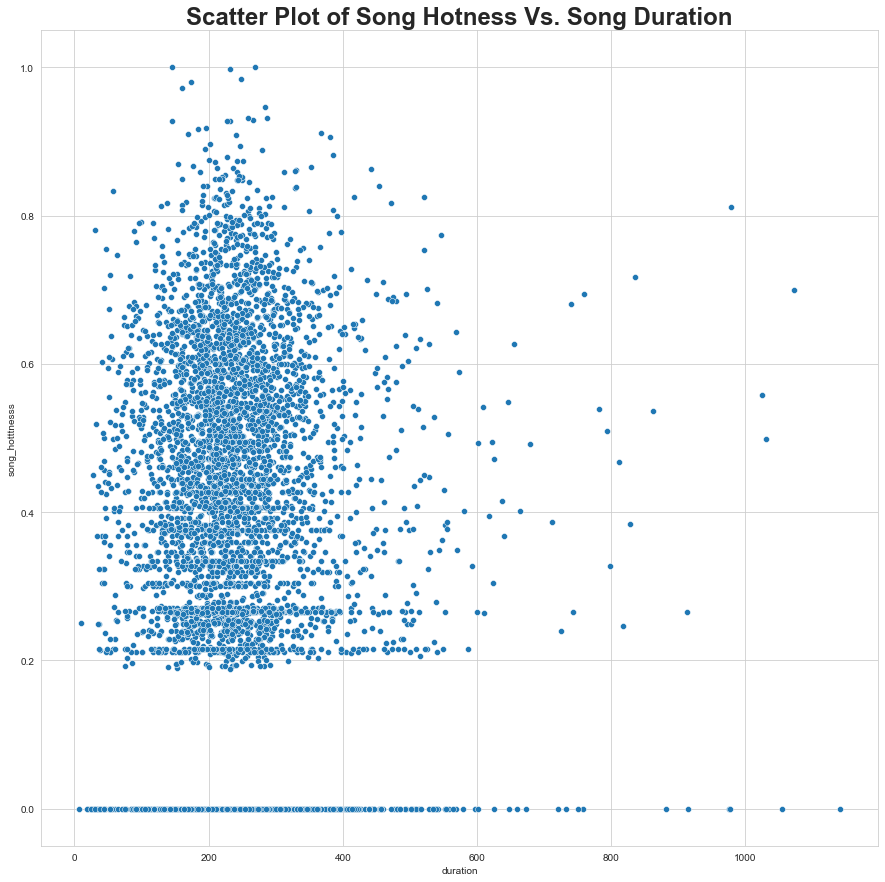

In [50]:
# song hotness vs duration (removing outliers to make points more visible)
sns.set_style('whitegrid')
plt.figure(figsize = (15, 15))
ax = sns.scatterplot(data = full_query_df[full_query_df['duration'] < 1200], x = 'duration', y = 'song_hotttnesss')
plt.title('Scatter Plot of Song Hotness Vs. Song Duration', fontweight = 'bold', fontsize = 24)

In [51]:
# split of major vs minor key songs
full_query_df['mode'].value_counts()

1    6911
0    3089
Name: mode, dtype: int64

In [52]:
# energy values in data 
full_query_df['energy'].value_counts()

0    10000
Name: energy, dtype: int64

In [11]:
# danceability values in the data
full_query_df['danceability'].value_counts()

0    10000
Name: danceability, dtype: int64

In [12]:
# sample rate values in the data
full_query_df['analysis_sample_rate'].value_counts()

22050    10000
Name: analysis_sample_rate, dtype: int64

In [15]:
# genre values in the data
full_query_df['genre'].value_counts()

Series([], Name: genre, dtype: int64)

Text(0.5, 1.0, 'Scatter Plot of Artist Familiarity Vs. Artist Hotness')

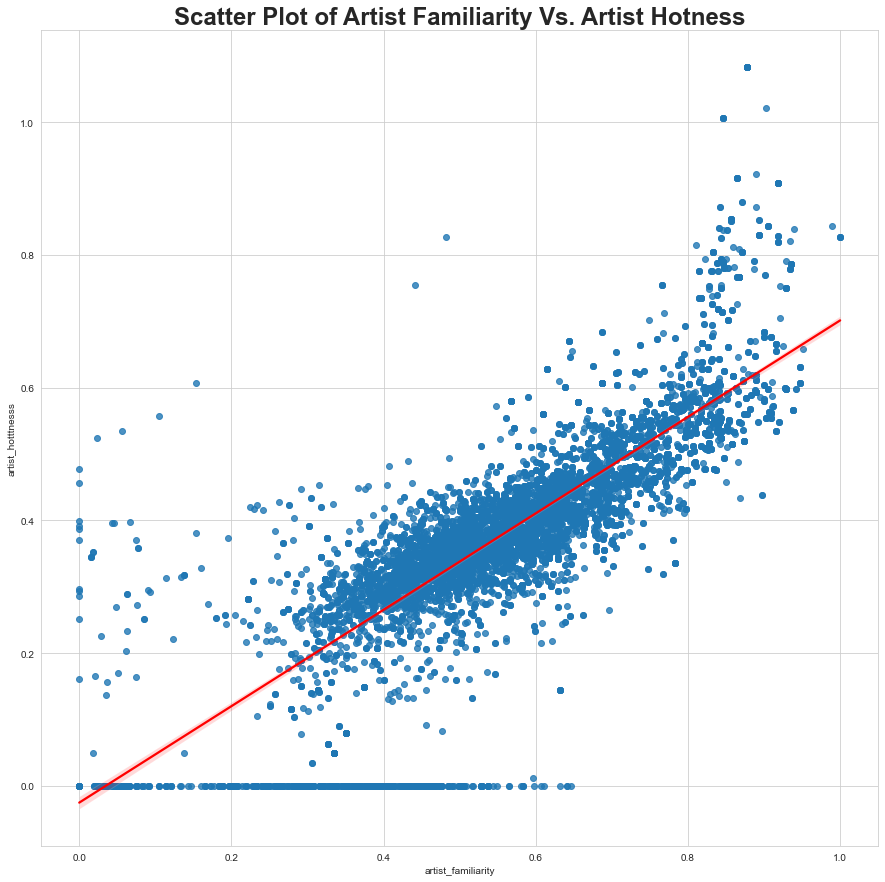

In [57]:
# artist familiarity vs artist hotness 
plt.figure(figsize = (15, 15))
ax = sns.regplot(data = full_query_df, x = 'artist_familiarity', y = 'artist_hotttnesss', line_kws = {'color': 'red'})
plt.title('Scatter Plot of Artist Familiarity Vs. Artist Hotness', fontweight = 'bold', fontsize = 24)

Text(0.5, 1.0, 'Scatter Plot of Artist Familiarity Vs. Song Hotness')

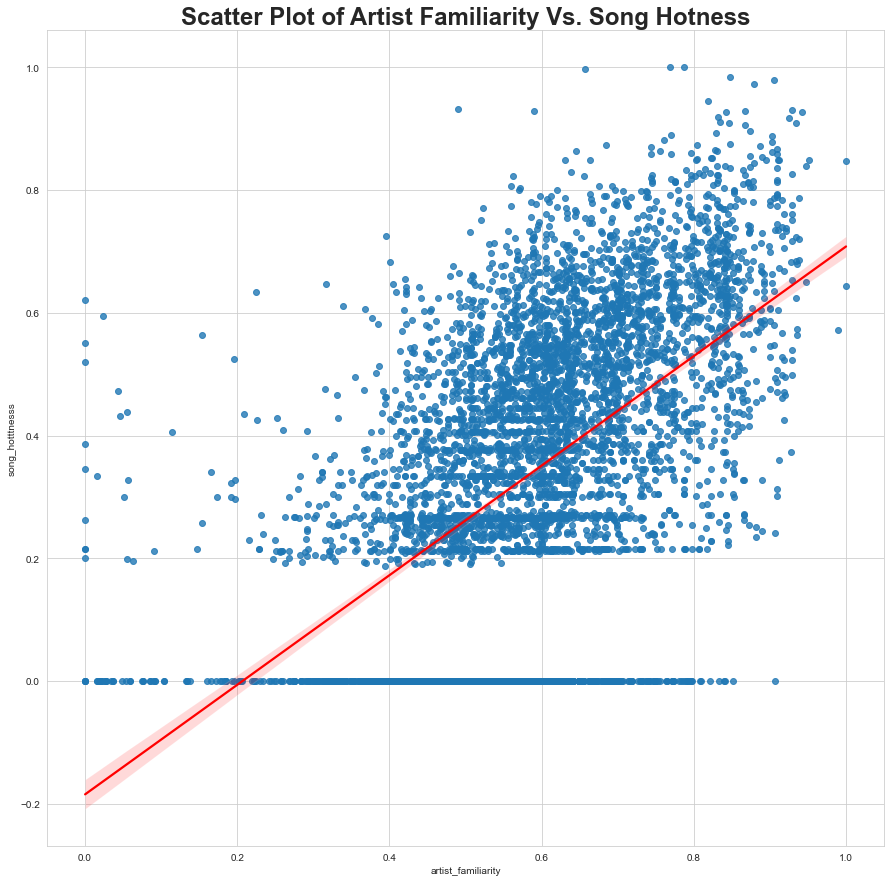

In [58]:
# artist familiarity vs song hotness 
plt.figure(figsize = (15, 15))
ax = sns.regplot(data = full_query_df, x = 'artist_familiarity', y = 'song_hotttnesss', line_kws = {'color': 'red'})
plt.title('Scatter Plot of Artist Familiarity Vs. Song Hotness', fontweight = 'bold', fontsize = 24)

In [169]:
def get_decade(year):
    '''returns decade the song is from
    '''
    if year >= 1920 and year < 1930:
        return 1920
    elif year >= 1930 and year < 1940:
        return 1930
    elif year >= 1940 and year < 1950:
        return 1940
    elif year >= 1950 and year < 1960:
        return 1950
    elif year >= 1960 and year < 1970:
        return 1960
    elif year >= 1970 and year < 1980:
        return 1970
    elif year >= 1980 and year < 1990:
        return 1980
    elif year >= 1990 and year < 2000:
        return 1990
    elif year >= 2000 and year < 2010:
        return 2000
    elif year >= 2010 and year <= 2020:
        return 2010

# going to predict which decade a song was released in so need to create a new column called decade 
full_query_df['decade'] = full_query_df['year'].apply(get_decade)
full_query_df.head()

,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year,decade
0,TRBGJCT128F933A606,SOBBQDL12A58A7A988,100 Club 1996 ''We Love You Beatles'' - Live,5195440,22050,40f155321c40015d95c7815033a54e15,0,88.73751,0.298,0,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{{0.97,1.0,0.502,0.362,0.352,0.377,0.356,0.259...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{punk,italy,""british punk rock"",soundtrack,""pr...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...","{ARNTVM11187B98B4B4,AREKBBQ11F50C4971D,ARNFTGS...",414,0.731184,0.549204,ARD3LXU1187B9ABFC5,NaN,NaN,NaN,e5db18cb-4b1f-496d-a308-548b611090d3,Sex Pistols,1418,NaN,Sex Pistols - The Interviews,467088,NaN,"{british,""punk rock"",uk,london,england,english...","{4,3,3,1,1,1,1,1,1,1}",0,NaN
1,TRBGJOG12903CC3E93,SOIZHEV12A8C14138B,Yo Quiero Contigo,7948828,22050,88ff14072530c24e4a71dc36d8cfcd4d,0,167.36608,5.851,0,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{{0.828,0.564,0.238,0.302,1.0,0.8,0.808,0.586,...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{{27.46,-55.217,73.516,-97.74,29.328,151.265,7...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{reggaeton,""los angeles"",california,""hip hop"",...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...","{AROTGDJ12454A52E29,ARYFNBU12454A4D74D,ARROGBH...",170931,0.610186,0.355320,ARWWPKQ11F4C83D8E2,NaN,NaN,NaN,NaN,Baby Rasta & Gringo,-1,NaN,Sentenciados - Platinum Edition,716669,NaN,{},{},0,NaN
2,TRBGJFN128F429AB79,SOHFGYR12A8C13AE07,Vankina vapauden,1170609,22050,77ab2a1f981525fea9c68f3b6958e402,0,189.36118,5.515,0,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0

In [170]:
# check decades
full_query_df['decade'].value_counts()

2000.0    2543
1990.0    1205
1980.0     439
1970.0     246
1960.0     137
2010.0      64
1950.0      30
1930.0       6
1920.0       6
1940.0       4
Name: decade, dtype: int64

In [172]:
full_query_df[full_query_df['decade'] == 1920]

,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year,decade
1730,TRBFMCN128F423625D,SOJBKMX12A8AE47E72,Got The Blues,1989828,22050,f8f841061c127d4ab7d758d4e1096f4e,0,175.15057,0.560,0,4,0.180,-19.239,1,0.112,166.522,101.676,3,0.607,"{0.098,0.33,0.177,0.257,0.105,0.141,0.177,0.33...","{0.50705,2.31819,4.10567,5.89316,7.50487,9.304...","{0.751,0.341,0.0,0.373,0.361,0.513,0.308,0.365...","{0.50705,1.1014,1.71053,2.31819,2.9214,3.51723...","{1.0,0.687,0.118,0.224,0.587,0.166,0.227,0.157...","{0.0,8.05067,22.19084,29.62145,60.80902,76.735...","{0.0,0.549,0.664,0.535,0.58,1.0,0.753,0.579,0....","{-59.366,-54.809,-44.954,-36.269,-33.083,-21.0...","{0.28733,0.10982,0.25403,0.17075,0.02636,0.119...","{-60.0,-59.867,-54.87,-45.405,-36.451,-36.893,...","{{0.706,0.856,1.0,0.649,0.531,0.651,0.644,0.81...","{0.0,0.56,0.67619,0.94961,1.12902,1.30871,1.83...","{{0.075,169.637,6.645,-30.322,55.116,-50.055,1...","{0.225,0.224,0.242,0.231,0.2,0.179,0.16,0.145,...","{0.50705,0.80422,1.1014,1.40597,1.71053,2.0151...","{""country blues"",""delta blues"",""texas blues"",b...","{0.9503496240621959,0.9158607134697939,0.88264...","{1.0,0.9720548519063476,0.9451393549535105,0.9...","{ARHNCQ31187B9915DC,ARDK0551187FB5AC48,ARRU9GR...",8588,0.594867,0.382847,ARE36MM1187B991E50,31.16890,-100.07715,"Couchman, TX",9481010a-db23-469d-87df-b04118850efb,Blind Lemon Jefferson,16298,NaN,The Complete Classic Sides Remastered: Chicago...,183909,NaN,"{blues,american}","{1,1}",1926,1920.0
2200,TRBHUOU128F423625E,SOCSUYP12A58A79438,Long Lonesome Blues,1989829,22050,f8088a888eb97229a31de72ca57178ca,0,178.38975,0.584,0,1,0.053,-24.106,1,0.428,173.337,100.329,4,0.073,"{0.021,0.836,0.153,0.256,0.778,0.523,0.685,0.6...","{1.00613,3.43369,5.79978,7.97187,10.27026,12.6...","{1.0,0.802,0.651,0.667,0.763,0.725,0.723,0.753...","{0.42734,1.00613,1.5924,2.20866,2.82043,3.4336...","{1.0,0.75,0.14,0.232,0.317,0.312,0.313,0.037,0...","{0.0,7.97187,56.48151,76.71202,97.78363,117.17...","{0.0,0.461,0.679,0.532,0.581,0.886,0.278,0.834...","{-59.527,-55.779,-45.974,-37.415,-31.962,-26.9...","{0.28144,0.07807,0.23605,0.16647,0.22943,0.021...","{-60.0,-59.719,-55.684,-46.452,-37.472,-32.156...","{{0.67,0.817,1.0,0.653,0.508,0.632,0.626,0.806...","{0.0,0.58354,0.68789,0.94358,1.12313,1.36082,1...","{{0.056,170.014,7.384,-29.813,55.764,-49.998,1...","{0.161,0.167,0.153,0.148,0.155,0.162,0.139,0.1...","{0.42734,0.71973,1.00613,1.28952,1.5924,1.9012...","{""country blues"",""delta blues"",""texas blues"",b...","{0.9503496240621959,0.9158607134697939,0.88264...","{1.0,0.9720548519063476,0.9451393549535105,0.9...","{ARHNCQ31187B9915DC,ARDK0551187FB5AC48,ARRU9GR...",8588,0.594867,0.382847,ARE36MM1187B991E50,31.16890,-100.07715,"Couchman, TX",9481010a-db23-469d-87df-b04118850efb,Blind Lemon Jefferson,16298,NaN,The Complete Classic Sides Remastered: Chicago...,183909,NaN,"{blues,american}","{1,1}",1926,1920.0
2991,TRAGJGZ128F421EE19,SODVIWU12A6D4FCDA6,Writing Paper Blues,1882191,22050,9c54dcf1c52137c7faca5a143e2fecd1,0,191.73832,0.224,0,3,0.623,-11.383,1,0.502,185.179,131.624,3,0.293,"{0.157,0.075,0.084,0.312,0.293,0.11,0.412,0.07...","{0.53989,1.9747,3.35591,4.77514,6.21709,7.6602...","{0.653,0.0,0.22,0.198,0.0,0.0,0.118,0.048,0.01...","{0.05963,0.53989,1.03084,1

Text(0.5, 1.0, 'Scatter Plot of Decade Vs. Song Hotness')

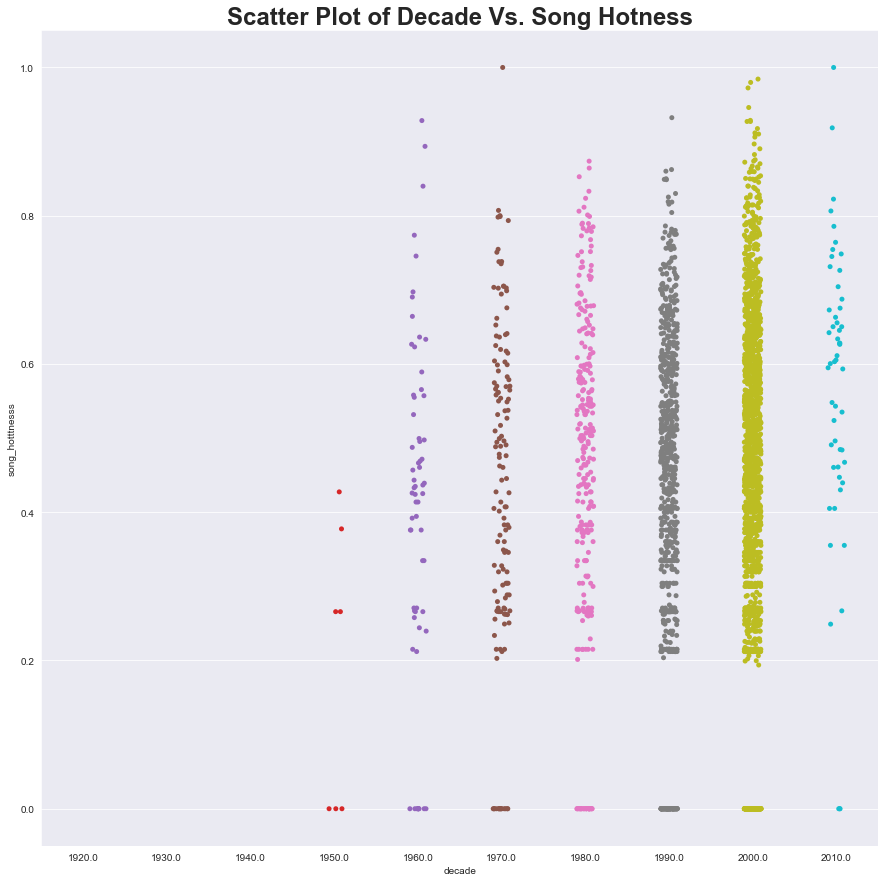

In [171]:
# decade vs song hotness 
plt.figure(figsize = (15, 15))
ax = sns.stripplot(data = full_query_df[full_query_df['decade'] != 0], x = 'decade', y = 'song_hotttnesss')
plt.title('Scatter Plot of Decade Vs. Song Hotness', fontweight = 'bold', fontsize = 24)

Text(0.5, 1.0, 'Scatter Plot of Decade Vs. Artist Hotness')

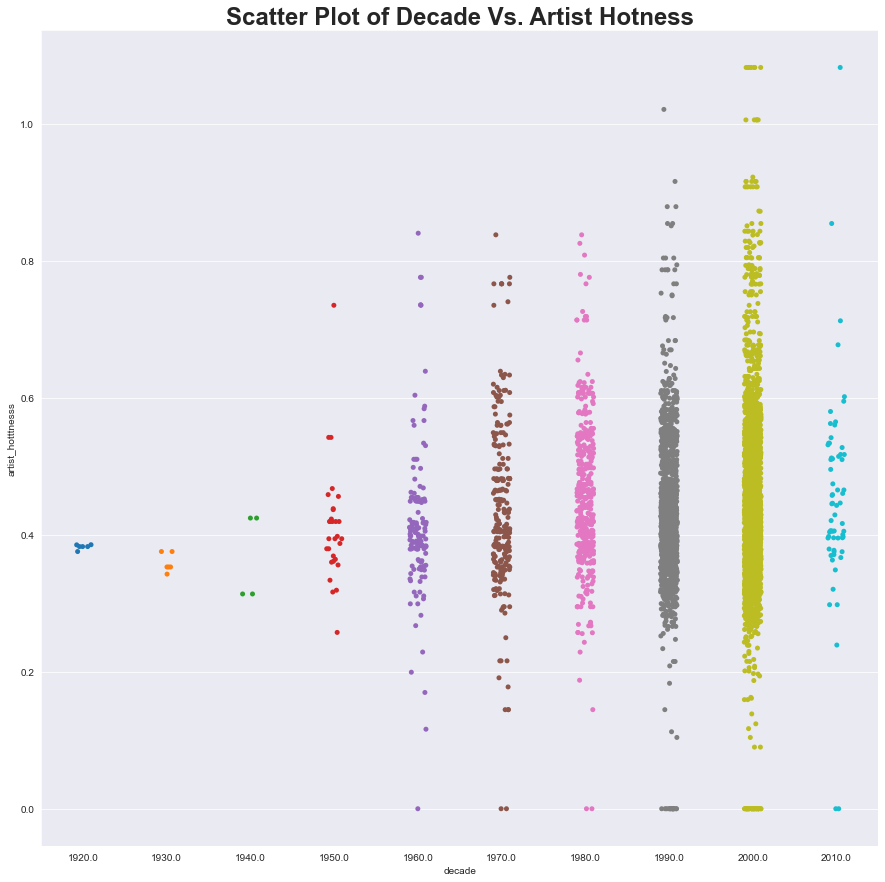

In [173]:
# decade vs Artist hotness 
plt.figure(figsize = (15, 15))
ax = sns.stripplot(data = full_query_df[full_query_df['decade'] != 0], x = 'decade', y = 'artist_hotttnesss')
plt.title('Scatter Plot of Decade Vs. Artist Hotness', fontweight = 'bold', fontsize = 24)

Text(0.5, 1.0, 'Boxplot of Artist Familiarity Grouped by Year')

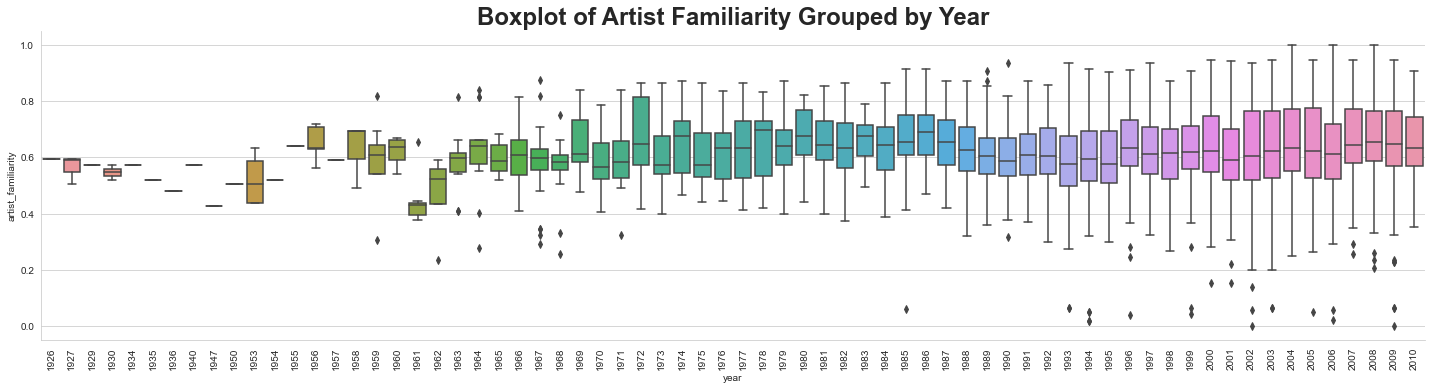

In [59]:
# boxplot of artist familiarity by year
ax = sns.catplot(kind = 'box', x = 'year', y = 'artist_familiarity', data = query_df, aspect = 4, height = 5)
plt.xticks(rotation = 90)
plt.title('Boxplot of Artist Familiarity Grouped by Year', fontweight = 'bold', fontsize = 24)

Text(0.5, 1.0, 'Boxplot of Seconds at the Beginning of the Song Grouped by Year')

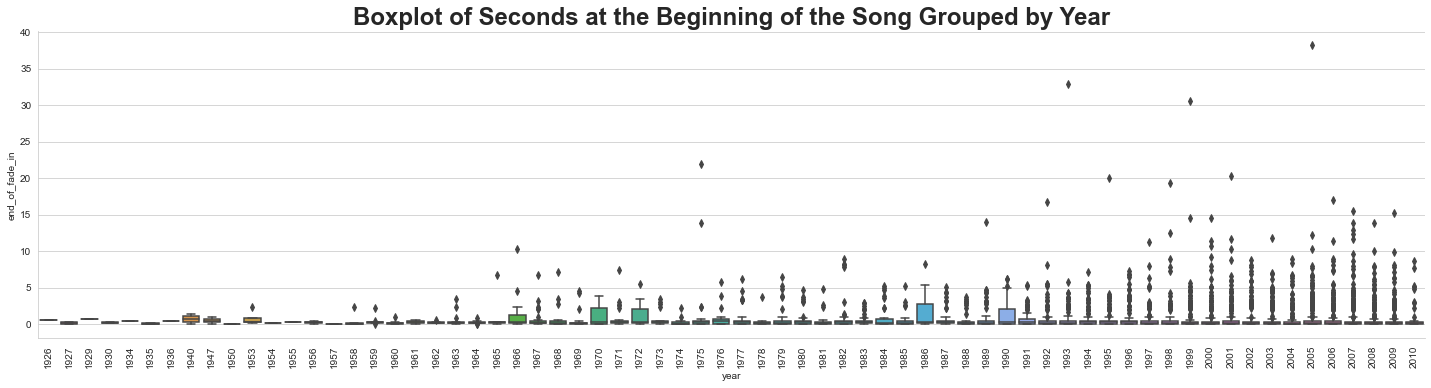

In [61]:
# boxplot of end of fade in by year
ax = sns.catplot(kind = 'box', x = 'year', y = 'end_of_fade_in', data = query_df, aspect = 4, height = 5)
plt.xticks(rotation = 90)
plt.title('Boxplot of Seconds at the Beginning of the Song Grouped by Year', fontweight = 'bold', fontsize = 24)

Text(0.5, 1.0, 'Boxplot of Time of the Fade Out Grouped by Year')

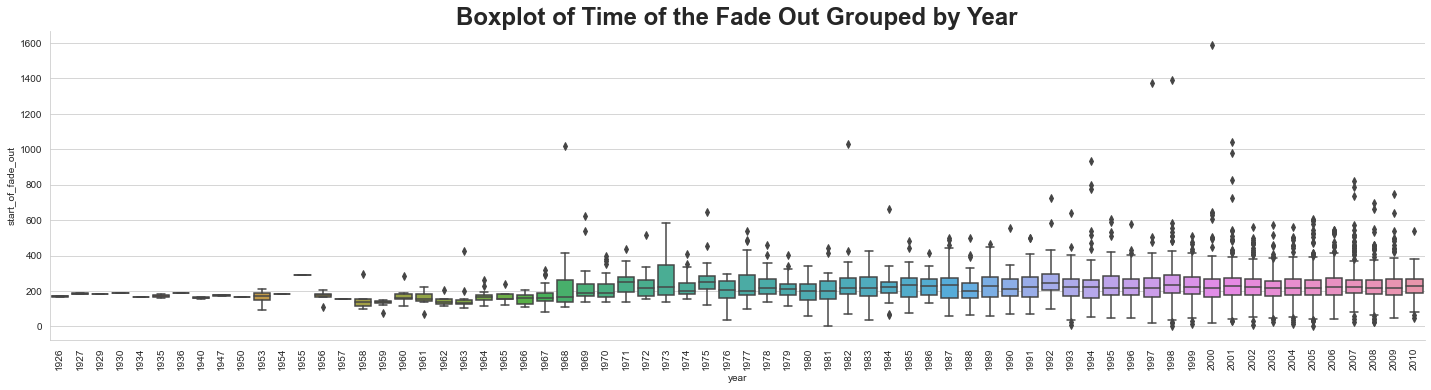

In [62]:
# boxplot of start of the fade out by year
ax = sns.catplot(kind = 'box', x = 'year', y = 'start_of_fade_out', data = query_df, aspect = 4, height = 5)
plt.xticks(rotation = 90)
plt.title('Boxplot of Time of the Fade Out Grouped by Year', fontweight = 'bold', fontsize = 24)

In [81]:
# map artist locations
# first have to grab songs with valid artist_longitude and artist_latitude values
valid_coordinates_df = full_query_df[~(full_query_df['artist_latitude'].isna())]

# create point pairs from lat and long coordinates
coordinate_points = [Point(xy) for xy in zip(valid_coordinates_df['artist_longitude'], valid_coordinates_df['artist_latitude'])]

# create GeoDataFrame 
valid_coordinates_geodf = gpd.GeoDataFrame(valid_coordinates_df, crs = {'init': 'epsg:4326'}, geometry = coordinate_points)
valid_coordinates_geodf

C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,track_id,song_id,title,track_7digitalid,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,tatums_confidence,tatums_start,artist_terms,artist_terms_freq,artist_terms_weight,similar_artists,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_longitude,artist_location,artist_mbid,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,artist_mbtags,artist_mbtags_count,year,geometry
2,TRBGJFN128F429AB79,SOHFGYR12A8C13AE07,Vankina vapauden,1170609,22050,77ab2a1f981525fea9c68f3b6958e402,0,189.36118,5.515,0,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-60.0,-25.988,-21.889,-16.438,-14.986,-15.943...","{0.0,0.14095,0.07411,0.24673,0.17503,0.07992,0...","{-60.0,-60.0,-26.796,-22.478,-16.804,-18.654,-...","{{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...","{0.0,4.3044,4.48494,4.57152,4.83855,5.11701,5....","{{0.0,171.13,9.469,-28.48,57.491,-50.067,14.83...","{0.0,0.0,0.0,0.084,0.109,0.134,0.158,0.185,0.2...","{0.32976,0.64188,0.954,1.26612,1.58002,1.88456...","{""neue deutsche welle"",""progressive trance"",""t...","{0.8578314815785183,0.8755938366555721,0.83279...","{1.0,0.9621596827214342,0.9564520569969458,0.9...","{AR4SOKG1187B98D2B0,AR6KB411187FB40C09,ARERIMH...",23485,0.537533,0.343884,AR6BUE51187B9B5D71,37.82245,-85.69091,Kentucky,ec23ec07-1c34-47f7-9dbe-ef1a47a305f1,Markus,-1,NaN,20 Suosikkia / Jos vielä oot vapaa,113407,NaN,{},{},0,POINT (-85.69091 37.82245)
4,TRBGJZN12903D0D2FC,SOKMTOP12AC468980A,Emerald,7761766,22050,6b64c74c1595a7f840e1725062ac56ec,0,501.86404,0.000,0,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,"{0.957,0.716,0.281,0.146,0.093,0.202,0.1,0.564...","{0.89503,2.74044,4.58714,6.43382,8.27926,10.12...","{1.0,1.0,1.0,0.958,0.615,0.605,0.514,0.962,1.0...","{0.43242,0.89503,1.35628,1.81753,2.27956,2.740...","{1.0,0.168,0.337,0.446,1.0,1.0,1.0,0.241,0.066...","{0.0,14.2806,45.20694,80.74071,162.8994,177.66...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{-29.298,-28.07,-14.076,-27.513,-14.988,-27.72...","{0.20317,0.00926,0.02198,0.02842,0.02253,0.010...","{-60.0,-51.502,-59.719,-51.718,-46.497,-51.434...","{{1.0,0.94,0.717,0.57,0.512,0.396,0.108,0.23,0...","{0.0,0.20354,0.42091,0.6449,0.87964,1.12562,1....","{{10.432,-47.756,-229.034,-108.474,-31.688,-16...","{1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...","{0.20169,0.43242,0.6643,0.89503,1.12565,1.3562...","{""progressive house"",""progressive trance"",""tec...","{1.0,0.9862037285015448,0.8886521610598996,0.9...","{1.0,0.9696513385348325,0.9168794583576614,0.9...","{ARSS3WR1187B98EE9F,ARCYE581187B9A1482,AROZNFA...",304705,0.654039,0.390625,ARFN4JN1187B98C627,-22.96566,18.48617,Detroit,3c34ad84-7628-459e-949d-c27e2ae73231,Bedrock,-1,NaN,Emerald,699533,NaN,{},{},2004,POINT (18.48617 -22.96566)
6,TRBGJDW128F4292EDB,SODHTCY12A58A7F125,Karma,3358987,22050,cd8980dbf1346e4a9d24dd815670091b,0,255.99955,0.177,0,7,0.267,-6.155,0,0.324,253.498,113.485,3,1.000,"{0.09,0.136,0.29,0.06,0.26,0.22,0.176,0.113,0....","{1.08556,2.67647,4.26478,5.85043,7.43605,9.023...","{0.309,0.349,0.379,0.548,0.494,0.303,0.651,0.2...","{0.55496,1.08556,1.61615,2.14411,2.67647,3.207...","{1.0,0.82,0.22,0.419,0.453,0.186,0.496,0.278,0...","{0.0,22.23993,48.67053,71.40721,91.51556,113.6...","{0.0,1.0,0.994,1.0,1.0,1.0,1.0

<AxesSubplot:title={'center':'Artist Locations'}>

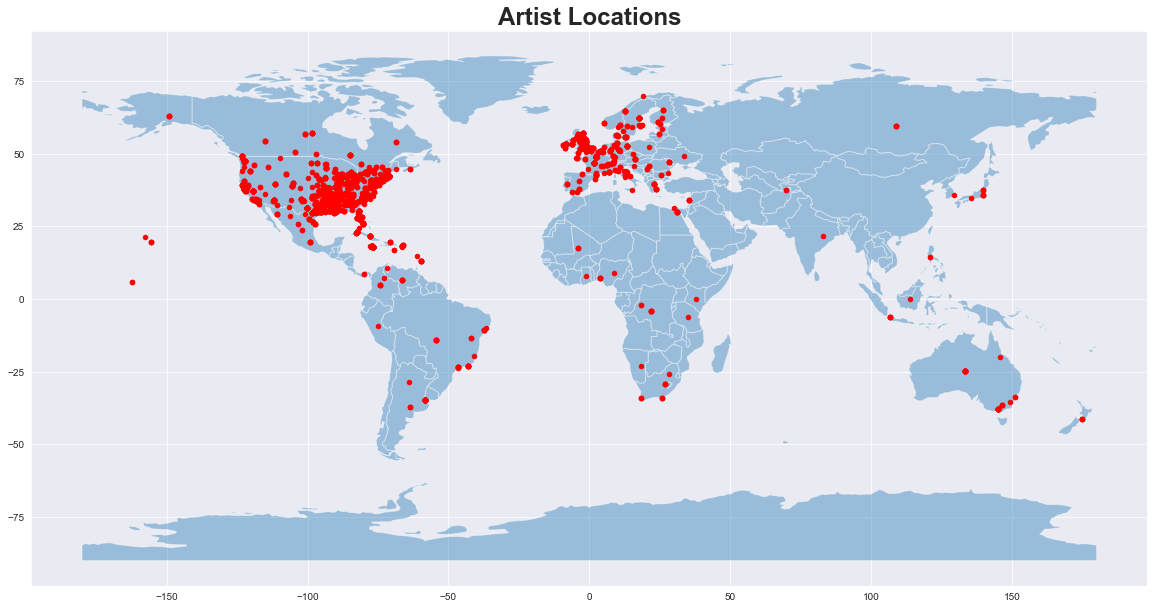

In [82]:
# world plot 
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize = (20, 20))
world_map.plot(ax = ax, alpha = 0.4)
plt.title('Artist Locations', fontweight = 'bold', fontsize = 24)
valid_coordinates_geodf.plot(ax = ax, markersize = 20, color = 'red')

# Data Wrangling

First we need to deal with data fields that are arrays. To convert these into single term features we are going to take the average of the lists. 

In [103]:
# first drop the columns that will not be included as features for modelling (this includes any feature that are not relevant (i.e. title) and any fields that only include one value (i.e. analysis_sample_rate is always 22050 and danceability is always 0))
# artist coordinates (lat/long and location) are dropped because a majority of the records does not have locaiton values and we have no good way to fill those values for the NaN entries
modelDf = full_query_df.drop(['track_id', 'song_id', 'title', 'track_7digitalid', 'analysis_sample_rate', 'audio_md5', 'danceability', 'energy', 'similar_artists', 'artist_7digitalid', 'artist_id', 'artist_mbid', 'artist_name', 'genre', 'release', 'release_7digitalid', 'artist_mbtags', 'artist_mbtags_count', 'segments_timbre', 'segments_pitches', 'artist_terms', 'artist_playmeid', 'artist_latitude', 'artist_longitude', 'artist_location'], axis = 1)
modelDf.head()

,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_start,tatums_confidence,tatums_start,artist_terms_freq,artist_terms_weight,artist_familiarity,artist_hotttnesss,song_hotttnesss,year
0,88.73751,0.298,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...",0.731184,0.549204,NaN,0
1,167.36608,5.851,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...",0.610186,0.355320,NaN,0
2,189.36118,5.515,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-60.0,-25.988,-21.889,-16.438,-14.986,-15.943...","{0.0,0.14095,0.07411,0.24673,0.17503,0.07992,0...","{-60.0,-60.0,-26.796,-22.478,-16.804,-18.654,-...","{0.0,4.3044,4.48494,4.57152,4.83855,5.11701,5....","{0.0,0.0,0.0,0.084,0.109,0.134,0.158,0.185,0.2...","{0.32976,0.64188,0.954,1.26612,1.58002,1.88456...","{0.8578314815785183,0.8755938366555721,0.83279...","{1.0,0.9621596827214342,0.9564520569969458,0.9...",0.537533,0.343884,NaN,0
3,232.93342,0.467,5,0.180,-19.664,1,0.072,218.041,173.828,4,0.070,"{0.047,0.089,0.331,0.171,0.053,0.035,0.064,0.0...","{0.16883,1.55819,2.92845,4.27181,5.64208,7.050...","{0.665,0.671,0.352,0.525,0.58,0.684,0.58,0.609...","{0.16883,0.52072,0.86655,1.21237,1.55819,1.897...","{1.0,0.596,0.595,0.424,0.367,0.284,0.36,1.0}","{0.0,17.26536,36.75491,62.15578,115.26587,169....","{0.0,1.0,1.0,1.0,0.469,0.761,0.006,1.0,0.971,0...","{-60.0,-36.505,-19.442,-21.31,-36.138,-30.523,...","{0.0,0.09543,0.04573,0.0328,0.03268,0.03446,0....","{-60.0,-60.0,-38.975,-37.527,-42.0,-39.292,-44...","{0.0,0.4673,0.61306,1.01923,1.29755,1.41143,1....","{0.281,0.276,0.274,0.253,0.231,0.221,0.194,0.1...","{0.16883,0.34217,0.52072,0.68799,0.86655,1.039...","{0.9695085377146491,0.9695085377146491,0.96950...","{1.0,0.9815510582821861,0.9711725140034239,0.8...",0.394768,0.175411,NaN,0
4,501.86404,0.000,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,"{0.957,0.716,0.281,0.146,0.093,0.202,0.1,0.564...","{0.8950

In [104]:
def convert_to_list(row):
    '''custom apply function for pandas dataframe 
    
    converts dataframe field that is in a string set format '{ . . .}' into a list format [ . . . ]
    '''
    return list(ast.literal_eval(row))

def average_feature(feature):
    '''returns the average of the array feature

    Parameters
    ----------
    feature : string
        the feature to average out
    '''
    # first have to convert the string set (i.e. data format is '{...}') to a list of floats
    tmp = modelDf[feature].apply(convert_to_list)
    return tmp.apply(lambda col : np.mean(col))

# each feature that needs to be averaged and whether it is a 1d or 2d array 
features_to_average = ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'sections_confidence', 'segments_loudness_max', 'segments_loudness_max_time', 'segments_loudness_start', 'segments_start', 'tatums_confidence', 'tatums_start','artist_terms_freq', 'artist_terms_weight', 'sections_start', 'segments_confidence']

# loop thorugh the features and add a new field for the averaged value 
for feature in features_to_average:
    print('feature: ' + feature)
    modelDf[feature + '_mean'] = average_feature(feature)
    print('done')
    print('-----------------------')

modelDf.head()

feature: bars_confidence


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: bars_start


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: beats_confidence


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: beats_start


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: sections_confidence


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: segments_loudness_max
done
-----------------------
feature: segments_loudness_max_time
done
-----------------------
feature: segments_loudness_start
done
-----------------------
feature: segments_start
done
-----------------------
feature: tatums_confidence


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: tatums_start


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: artist_terms_freq


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: artist_terms_weight


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: sections_start


C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


done
-----------------------
feature: segments_confidence
done
-----------------------


,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,bars_confidence,bars_start,beats_confidence,beats_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_start,tatums_confidence,tatums_start,artist_terms_freq,artist_terms_weight,artist_familiarity,artist_hotttnesss,song_hotttnesss,year,bars_confidence_mean,bars_start_mean,beats_confidence_mean,beats_start_mean,sections_confidence_mean,segments_loudness_max_mean,segments_loudness_max_time_mean,segments_loudness_start_mean,segments_start_mean,tatums_confidence_mean,tatums_start_mean,artist_terms_freq_mean,artist_terms_weight_mean,sections_start_mean,segments_confidence_mean
0,88.73751,0.298,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,"{0.124,0.112,0.096,0.215,0.054,0.143,0.114,0.1...","{1.05277,2.68331,4.22783,5.88498,7.44629,8.893...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.371,0.166,0.959}","{0.0,35.743,51.07955,83.16827}","{0.0,1.0,0.95,0.212,0.888,0.303,0.343,1.0,0.88...","{-60.0,-14.114,-13.495,-12.97,-13.733,-11.403,...","{0.0,0.14916,0.02785,0.05477,0.08291,0.04679,0...","{-60.0,-60.0,-27.538,-16.692,-25.007,-14.495,-...","{0.0,0.29846,0.56594,0.78739,1.04821,1.14653,1...","{0.79,0.92,0.696,0.626,0.587,0.519,0.485,0.47,...","{0.04606,0.37526,0.71941,1.05277,1.38778,1.729...","{1.0,0.5596462649523082,0.5100886604134174,0.3...","{1.0,0.7760465835458507,0.7415077362419781,0.4...",0.731184,0.549204,NaN,0,0.130379,43.877441,0.290179,44.248755,0.624000,-14.647142,0.077486,-24.758115,43.031855,0.290179,44.248755,0.400491,0.538768,42.497705,0.561624
1,167.36608,5.851,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,"{0.072,0.129,0.13,0.182,0.222,0.037,0.074,0.04...","{1.67692,4.54817,7.04522,9.49961,11.9417,14.38...","{0.349,0.519,0.296,0.501,0.128,0.0,0.427,0.233...","{0.53691,1.10301,1.67692,2.25482,2.82228,3.389...","{1.0,1.0,0.164,0.415,0.501,0.021,0.319,0.447,0...","{0.0,10.4801,42.25348,61.33113,71.11294,94.589...","{1.0,0.171,0.342,0.569,0.868,0.821,0.976,0.502...","{-24.193,-23.662,-26.904,-24.408,-19.328,-26.4...","{0.09915,0.06022,0.07353,0.04847,0.06487,0.044...","{-60.0,-26.43,-30.124,-29.522,-29.05,-37.009,-...","{0.0,0.18848,0.34,0.51361,1.05342,1.25002,1.64...","{0.256,0.258,0.259,0.26,0.254,0.274,0.271,0.26...","{0.15448,0.35045,0.53691,0.73003,0.91459,1.103...","{1.0,0.8120981752908923,0.8120981752908923,0.8...","{1.0,0.8843108934201204,0.8139725439930916,0.6...",0.610186,0.355320,NaN,0,0.097815,82.846856,0.401215,84.069476,0.393875,-11.095244,0.039967,-25.516877,85.894086,0.697450,83.987349,0.408899,0.578575,77.615904,0.639821
2,189.36118,5.515,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,"{1.0,0.175,0.103,0.136,0.088,0.243,0.112,0.284...","{1.26612,3.10739,5.00016,6.882,8.75449,10.6566...","{0.0,0.0,0.0,0.0,0.0,0.559,0.74,0.48,0.341,0.3...","{0.64188,1.26612,1.88456,2.47959,3.10739,3.733...","{1.0,1.0,0.397,0.01,0.195,0.517}","{0.0,5.00016,42.05266,54.24716,100.19433,129.2...","{0.0,1.0,0.491,0.446,0.334,0.161,0.75,0.194,0....","{-60.0,-25.988,-21.889,-16.438,-14.986,-15.943...","{0.0,0.14095,0.07411,0.24673,0.17503,0.07992,0...","{-60.0,-60.0,-26.796,-22.478,-16.804,-18.654,-...","{0.0,4.3044,4.48494,4.57152,4.83855,5.11701,5....","{0.0,0.0,0.0,0.084,0.109,0.134,0.158,0.185,0.2...","{0.32976,0.64188,0.954,1.26612,1.58002,1.88456...","{0.8578314815785183,0.8755938366555721,0.83279...","{1.0,0.9621596827214342,0.9564520569969458,0.9...",0.537533,0.343884,NaN,0,0.170420,92.562167,0.373403,93.490331,0.423800,-12.866860,0.064816,-19.561491,94.261492,0.295929,93.336116,0.637474,0.751455,55.126917,0.512954
3,232.93342,0.467,5,0.180,-19.664,1,0.072,218.041,173.828,4,0.070,"{0.047,0.089,0.331,0.171,0.053,0.035,0.064,0.0...","{0.16883,1.55819,2.92845,4.27181,5.64208,7.050...","{0.665,0.671,0.352,0.525,0.58,0.684,0.58,0.60

In [105]:
# drop the array features now that we have their means 
modelDf.drop(features_to_average, axis = 1, inplace = True)
modelDf.head()

,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,artist_familiarity,artist_hotttnesss,song_hotttnesss,year,bars_confidence_mean,bars_start_mean,beats_confidence_mean,beats_start_mean,sections_confidence_mean,segments_loudness_max_mean,segments_loudness_max_time_mean,segments_loudness_start_mean,segments_start_mean,tatums_confidence_mean,tatums_start_mean,artist_terms_freq_mean,artist_terms_weight_mean,sections_start_mean,segments_confidence_mean
0,88.73751,0.298,2,0.031,-11.229,0,0.331,88.738,190.333,5,0.562,0.731184,0.549204,NaN,0,0.130379,43.877441,0.290179,44.248755,0.624000,-14.647142,0.077486,-24.758115,43.031855,0.290179,44.248755,0.400491,0.538768,42.497705,0.561624
1,167.36608,5.851,4,0.049,-8.383,0,0.236,167.366,122.701,5,0.472,0.610186,0.355320,NaN,0,0.097815,82.846856,0.401215,84.069476,0.393875,-11.095244,0.039967,-25.516877,85.894086,0.697450,83.987349,0.408899,0.578575,77.615904,0.639821
2,189.36118,5.515,5,0.142,-10.819,0,0.319,185.481,97.103,3,1.000,0.537533,0.343884,NaN,0,0.170420,92.562167,0.373403,93.490331,0.423800,-12.866860,0.064816,-19.561491,94.261492,0.295929,93.336116,0.637474,0.751455,55.126917,0.512954
3,232.93342,0.467,5,0.180,-19.664,1,0.072,218.041,173.828,4,0.070,0.394768,0.175411,NaN,0,0.145918,113.313076,0.408927,114.350063,0.518000,-24.727524,0.053585,-35.711162,110.871837,0.205069,114.350256,0.599796,0.718375,100.745085,0.610217
4,501.86404,0.000,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,0.654039,0.390625,NaN,2004,0.388826,249.924660,0.736584,251.032532,0.436800,-17.912599,0.026980,-34.954022,250.381013,0.505198,251.032489,0.738283,0.736700,251.918495,0.568554


Now have to deal with NaN, null, and missing values

In [106]:
# check which fields have null values 
modelDf.isna().any()

duration                           False
end_of_fade_in                     False
key                                False
key_confidence                     False
loudness                           False
mode                               False
mode_confidence                    False
start_of_fade_out                  False
tempo                              False
time_signature                     False
time_signature_confidence          False
artist_familiarity                  True
artist_hotttnesss                  False
song_hotttnesss                     True
year                               False
bars_confidence_mean                True
bars_start_mean                     True
beats_confidence_mean               True
beats_start_mean                    True
sections_confidence_mean            True
segments_loudness_max_mean         False
segments_loudness_max_time_mean    False
segments_loudness_start_mean       False
segments_start_mean                False
tatums_confidenc

In [107]:
# fill null values with 0
modelDf['artist_familiarity'] = modelDf['artist_familiarity'].fillna(0)
modelDf['song_hotttnesss'] = modelDf['song_hotttnesss'].fillna(0)
modelDf['bars_confidence_mean'] = modelDf['bars_confidence_mean'].fillna(0)
modelDf['bars_start_mean'] = modelDf['bars_start_mean'].fillna(0)
modelDf['beats_confidence_mean'] = modelDf['beats_confidence_mean'].fillna(0)
modelDf['beats_start_mean'] = modelDf['beats_start_mean'].fillna(0)
modelDf['sections_confidence_mean'] = modelDf['sections_confidence_mean'].fillna(0)
modelDf['tatums_confidence_mean'] = modelDf['tatums_confidence_mean'].fillna(0)
modelDf['tatums_start_mean'] = modelDf['tatums_start_mean'].fillna(0)
modelDf['artist_terms_freq_mean'] = modelDf['artist_terms_freq_mean'].fillna(0)
modelDf['artist_terms_weight_mean'] = modelDf['artist_terms_weight_mean'].fillna(0)
modelDf['sections_start_mean'] = modelDf['sections_start_mean'].fillna(0)

# recheck if any rows still have null values 
modelDf.isna().any()

duration                           False
end_of_fade_in                     False
key                                False
key_confidence                     False
loudness                           False
mode                               False
mode_confidence                    False
start_of_fade_out                  False
tempo                              False
time_signature                     False
time_signature_confidence          False
artist_familiarity                 False
artist_hotttnesss                  False
song_hotttnesss                    False
year                               False
bars_confidence_mean               False
bars_start_mean                    False
beats_confidence_mean              False
beats_start_mean                   False
sections_confidence_mean           False
segments_loudness_max_mean         False
segments_loudness_max_time_mean    False
segments_loudness_start_mean       False
segments_start_mean                False
tatums_confidenc

In [125]:
# get records with valid year values 
data = modelDf[modelDf['year'] != 0]
data.head()

,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,artist_familiarity,artist_hotttnesss,song_hotttnesss,year,bars_confidence_mean,bars_start_mean,beats_confidence_mean,beats_start_mean,sections_confidence_mean,segments_loudness_max_mean,segments_loudness_max_time_mean,segments_loudness_start_mean,segments_start_mean,tatums_confidence_mean,tatums_start_mean,artist_terms_freq_mean,artist_terms_weight_mean,sections_start_mean,segments_confidence_mean
4,501.86404,0.000,6,0.041,-14.442,1,0.343,487.004,129.988,4,0.607,0.654039,0.390625,0.000000,2004,0.388826,249.924660,0.736584,251.032532,0.436800,-17.912599,0.026980,-34.954022,250.381013,0.505198,251.032489,0.738283,0.736700,251.918495,0.568554
6,255.99955,0.177,7,0.267,-6.155,0,0.324,253.498,113.485,3,1.000,0.933916,0.778674,0.723349,2003,0.199762,126.342160,0.363322,127.398249,0.475818,-10.108558,0.050745,-19.472003,125.804918,0.436119,127.222096,0.420059,0.458918,119.230847,0.557210
9,229.56363,0.202,2,0.500,-11.680,1,0.484,224.467,165.904,4,0.000,0.415140,0.249740,0.000000,1972,0.203389,113.451039,0.820607,114.536909,0.624800,-17.719683,0.030482,-35.726546,113.431695,0.708337,114.627371,0.981031,0.944465,120.075119,0.592767
12,247.74485,0.000,0,0.140,-13.546,1,0.378,236.466,120.444,4,0.609,0.475731,0.365842,0.000000,1980,0.116425,122.546262,0.603874,123.541817,0.516364,-16.299025,0.039886,-26.689394,125.213721,0.459020,123.541991,0.580473,0.652534,125.071443,0.548714
14,167.78404,0.374,4,0.022,-9.966,1,0.379,162.342,166.090,7,0.369,0.736677,0.526183,0.550647,1987,0.155400,80.245346,0.330421,81.195490,0.579667,-11.017262,0.062361,-14.869058,76.725192,0.124512,81.197433,0.703957,0.731394,79.843048,0.321528


<AxesSubplot:>

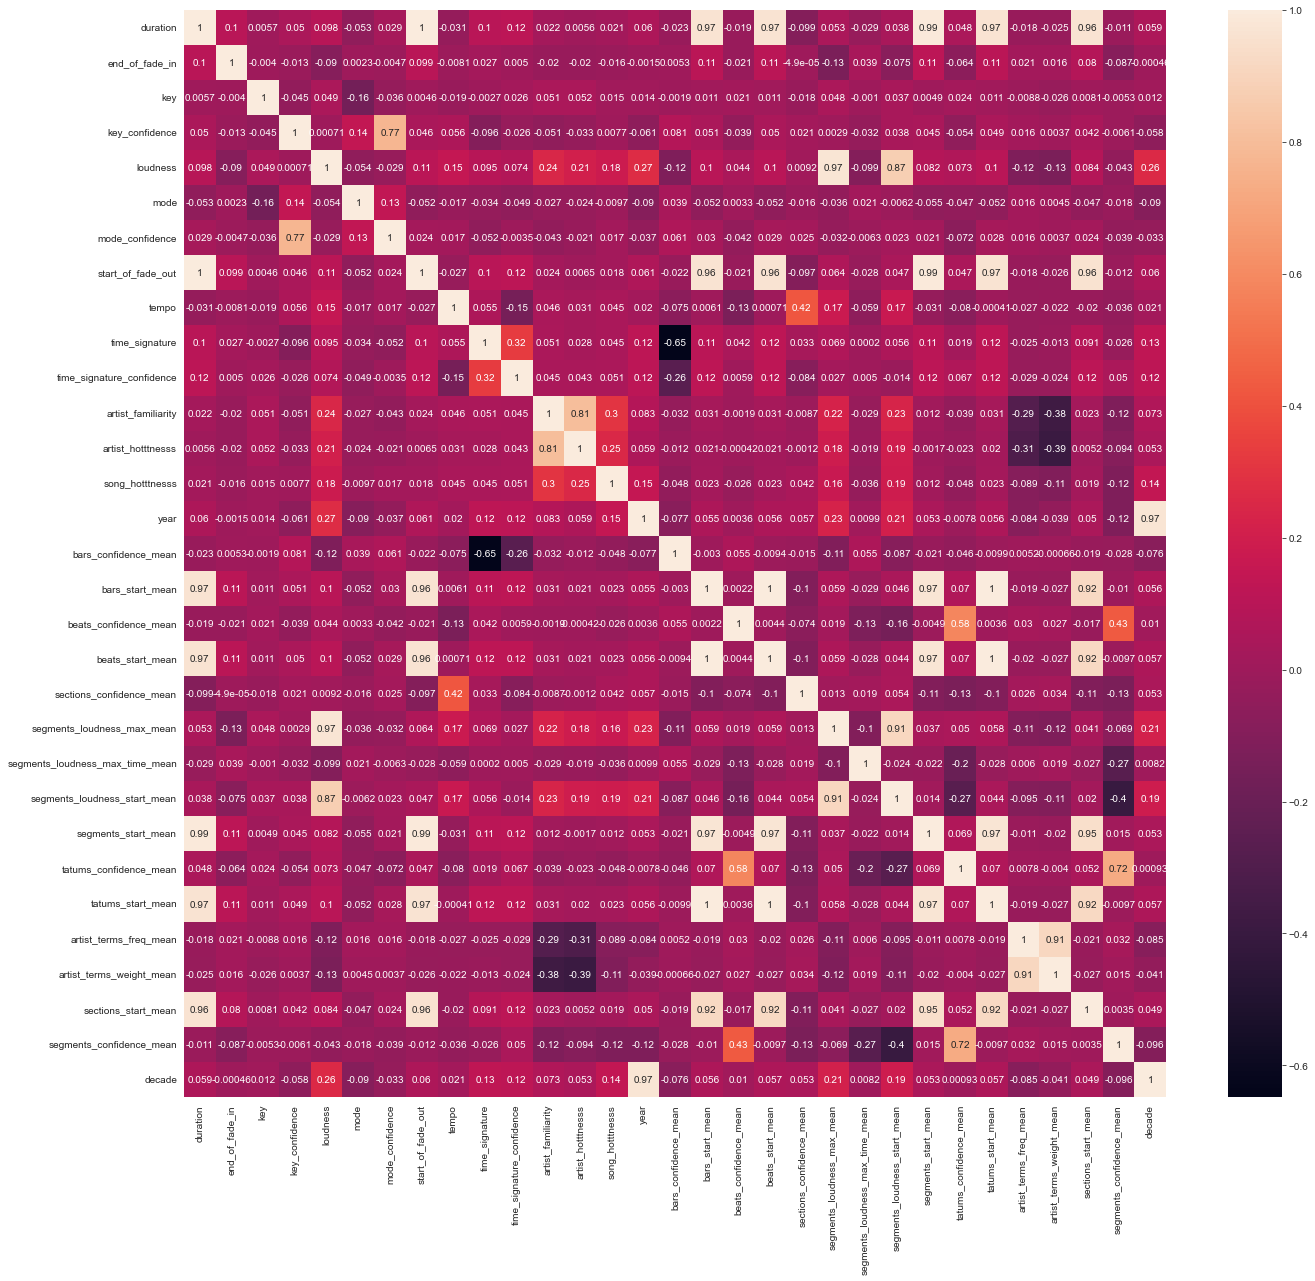

In [179]:
# correlation heatmap to check linear correlation between features (target feature is decade)
plt.figure(figsize = (22, 20))
sns.heatmap(data.corr(), annot = True)

# Modelling 

## Logistic Regression

Split into train/test splits

In [129]:
# split into train and test sets 
x = data.drop(['year', 'decade'], axis = 1)
y = data['decade']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8)

Now we need to scale the data 

In [151]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [152]:
# parameters to tune
c = [x for x in np.arange(0.0001, 2, 0.002)]
multi_class = ['ovr', 'multinomial']
max_iter = [x for x in np.arange(500, 1200, 75)]

# random grid search space 
log_param_grid = {'C': c, 'multi_class': multi_class, 'max_iter': max_iter}

In [153]:
# logistic regression grid search
log_reg = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions = log_param_grid, verbose = 2, n_iter = 250, cv = 3)
log_reg.fit(x_train, y_train)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV] END ............C=0.6361, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ............C=0.6361, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ............C=0.6361, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ...C=1.0301, max_iter=1100, multi_class=multinomial; total time=   0.2s
[CV] END ...C=1.0301, max_iter=1100, multi_class=multinomial; total time=   0.1s
[CV] END ...C=1.0301, max_iter=1100, multi_class=multinomial; total time=   0.1s
[CV] END C=0.8321000000000001, max_iter=950, multi_class=ovr; total time=   0.0s
[CV] END C=0.8321000000000001, max_iter=950, multi_class=ovr; total time=   0.0s
[CV] END C=0.8321000000000001, max_iter=950, multi_class=ovr; total time=   0.0s
[CV] END ....C=1.8581, max_iter=725, multi_class=multinomial; total time=   0.2s
[CV] END ....C=1.8581, max_iter=725, multi_class=multinomial; total time=   0.2s
[CV] END ....C=1.8581, max_iter=725, multi_cla

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=250,
                   param_distributions={'C': [0.0001, 0.0021, 0.0041, 0.0061,
                                              0.0081, 0.0101, 0.0121, 0.0141,
                                              0.0161, 0.0181, 0.0201,
                                              0.022099999999999998, 0.0241,
                                              0.0261, 0.0281, 0.0301,
                                              0.032100000000000004,
                                              0.034100000000000005,
                                              0.03610000000000001, 0.0381,
                                              0.040100000000000004,
                                              0.042100000000000005, 0.0441,
                                              0.0461, 0.048100000000000004,
                                              0.050100000000000006,
                                              0.052100000000

In [157]:
# best parameters from the random grid search 
log_reg.best_params_

{'multi_class': 'ovr', 'max_iter': 500, 'C': 0.17809999999999998}

In [160]:
log_reg_preds = log_reg.predict(x_test)
print(classification_report(y_test, log_reg_preds))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00         3
        1930       0.00      0.00      0.00         1
        1950       0.00      0.00      0.00         6
        1960       0.00      0.00      0.00        31
        1970       0.00      0.00      0.00        48
        1980       0.00      0.00      0.00        89
        1990       0.32      0.17      0.22       238
        2000       0.59      0.92      0.72       520

    accuracy                           0.56       936
   macro avg       0.11      0.14      0.12       936
weighted avg       0.41      0.56      0.46       936



C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Remove features with high multicollinearity

In [181]:
x2 = data.drop(['start_of_fade_out', 'bars_start_mean', 'beats_start_mean', 'segments_start_mean', 'tatums_start_mean', 'sections_start_mean', 'segments_loudness_max_mean', 'segments_loudness_start_mean', 'year', 'decade'], axis = 1)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size = 0.2, random_state = 8)

Scale the new train test splits

In [183]:
# scale the data
x2_train = scaler.fit_transform(x2_train)
x2_test = scaler.transform(x2_test)

In [184]:
# logistic regression grid search 
log_reg2 = RandomizedSearchCV(estimator = LogisticRegression(), param_distributions = log_param_grid, verbose = 2, n_iter = 250, cv = 3)
log_reg2.fit(x2_train, y2_train)

Fitting 3 folds for each of 250 candidates, totalling 750 fits
[CV] END C=0.08410000000000001, max_iter=575, multi_class=multinomial; total time=   0.0s
[CV] END C=0.08410000000000001, max_iter=575, multi_class=multinomial; total time=   0.0s
[CV] END C=0.08410000000000001, max_iter=575, multi_class=multinomial; total time=   0.0s
[CV] END ...C=0.6641, max_iter=1025, multi_class=multinomial; total time=   0.1s
[CV] END ...C=0.6641, max_iter=1025, multi_class=multinomial; total time=   0.0s
[CV] END ...C=0.6641, max_iter=1025, multi_class=multinomial; total time=   0.1s
[CV] END ............C=1.8841, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ............C=1.8841, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ............C=1.8841, max_iter=500, multi_class=ovr; total time=   0.0s
[CV] END ...........C=1.5141, max_iter=1025, multi_class=ovr; total time=   0.0s
[CV] END ...........C=1.5141, max_iter=1025, multi_class=ovr; total time=   0.0s
[CV] END ..........

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=250,
                   param_distributions={'C': [0.0001, 0.0021, 0.0041, 0.0061,
                                              0.0081, 0.0101, 0.0121, 0.0141,
                                              0.0161, 0.0181, 0.0201,
                                              0.022099999999999998, 0.0241,
                                              0.0261, 0.0281, 0.0301,
                                              0.032100000000000004,
                                              0.034100000000000005,
                                              0.03610000000000001, 0.0381,
                                              0.040100000000000004,
                                              0.042100000000000005, 0.0441,
                                              0.0461, 0.048100000000000004,
                                              0.050100000000000006,
                                              0.052100000000

In [185]:
# best parameters found 
log_reg2.best_params_

{'multi_class': 'ovr', 'max_iter': 800, 'C': 0.3321}

In [186]:
log_reg_preds2 = log_reg2.predict(x2_test)
print(classification_report(y2_test, log_reg_preds2))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00         3
        1930       0.00      0.00      0.00         1
        1950       0.00      0.00      0.00         6
        1960       0.00      0.00      0.00        31
        1970       0.00      0.00      0.00        48
        1980       0.00      0.00      0.00        89
        1990       0.31      0.15      0.20       238
        2000       0.59      0.93      0.72       520

    accuracy                           0.55       936
   macro avg       0.11      0.13      0.12       936
weighted avg       0.40      0.55      0.45       936



C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest    

In [187]:
# split into train and test sets 
x3 = data.drop(['year', 'decade'], axis = 1)
y3 = data['decade']

x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.2, random_state = 8)

No need to scale for random forest classifier

In [190]:
# parameters to tune
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]
max_features = ['auto', 'sqrt', 'log2']

# random grid search space 
rf_param_grid = {'n_estimators': n_estimators, 'max_features': max_features}

In [219]:
# random forest grid search 
rf = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs = -1), param_distributions = rf_param_grid, verbose = 2, n_iter = 150, cv = 3)
rf.fit(x3_train, y3_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV] END ................max_features=log2, n_estimators=854; total time=   4.5s
[CV] END ................max_features=log2, n_estimators=854; total time=   2.9s
[CV] END ................max_features=log2, n_estimators=854; total time=   3.2s
[CV] END ................max_features=sqrt, n_estimators=445; total time=   1.9s
[CV] END ................max_features=sqrt, n_estimators=445; total time=   1.7s
[CV] END ................max_features=sqrt, n_estimators=445; total time=   1.8s
[CV] END ................max_features=sqrt, n_estimators=318; total time=   1.4s
[CV] END ................max_features=sqrt, n_estimators=318; total time=   1.4s
[CV] END ................max_features=sqrt, n_estimators=318; total time=   1.4s
[CV] END ................max_features=log2, n_estimators=681; total time=   2.5s
[CV] END ................max_features=log2, n_estimators=681; total time=   2.5s
[CV] END ................max_features=log2, n_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=150,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 109, 118, 127,
                                                         136, 145, 154, 163,
                                                         172, 181, 190, 200,
                                                         209, 218, 227, 236,
                                                         245, 254, 263, 272,
                                                         281, 290, 300, 309,
                                                         318, 327, 336, 345,
                                                         354, 363, ...]},
                   verbose=2)

In [220]:
# best parameters found 
rf.best_params_

{'n_estimators': 381, 'max_features': 'auto'}

In [221]:
rf_preds = rf.predict(x3_test)
print(classification_report(y3_test, rf_preds))

              precision    recall  f1-score   support

        1920       0.00      0.00      0.00         3
        1930       0.00      0.00      0.00         1
        1950       0.00      0.00      0.00         6
        1960       0.00      0.00      0.00        31
        1970       0.00      0.00      0.00        48
        1980       0.25      0.01      0.02        89
        1990       0.32      0.21      0.25       238
        2000       0.61      0.91      0.73       520

    accuracy                           0.56       936
   macro avg       0.15      0.14      0.13       936
weighted avg       0.44      0.56      0.47       936



C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\prodb\anaconda3\envs\EMSE6586\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
# get the feature importances
importances = rf.best_estimator_.feature_importances_
feature_importances = pd.Series(importances, index = x3_train.columns)
feature_importances.sort_values(ascending = False)

loudness                           0.071878
segments_loudness_max_mean         0.051966
segments_loudness_start_mean       0.043707
segments_loudness_max_time_mean    0.042963
artist_familiarity                 0.042724
artist_terms_weight_mean           0.041509
bars_confidence_mean               0.039365
segments_confidence_mean           0.039199
tatums_confidence_mean             0.039067
artist_terms_freq_mean             0.038985
sections_confidence_mean           0.038974
artist_hotttnesss                  0.038329
beats_confidence_mean              0.038214
tempo                              0.037451
mode_confidence                    0.035703
key_confidence                     0.035558
end_of_fade_in                     0.034958
sections_start_mean                0.031590
time_signature_confidence          0.029845
start_of_fade_out                  0.028063
segments_start_mean                0.027718
song_hotttnesss                    0.026674
bars_start_mean                 

In [223]:
feature_importances.index

Index(['duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
       'mode', 'mode_confidence', 'start_of_fade_out', 'tempo',
       'time_signature', 'time_signature_confidence', 'artist_familiarity',
       'artist_hotttnesss', 'song_hotttnesss', 'bars_confidence_mean',
       'bars_start_mean', 'beats_confidence_mean', 'beats_start_mean',
       'sections_confidence_mean', 'segments_loudness_max_mean',
       'segments_loudness_max_time_mean', 'segments_loudness_start_mean',
       'segments_start_mean', 'tatums_confidence_mean', 'tatums_start_mean',
       'artist_terms_freq_mean', 'artist_terms_weight_mean',
       'sections_start_mean', 'segments_confidence_mean'],
      dtype='object')

Text(0.5, 1.0, 'Feature Importances Based on Mean Decrease in Impurity (Gini Importance)')

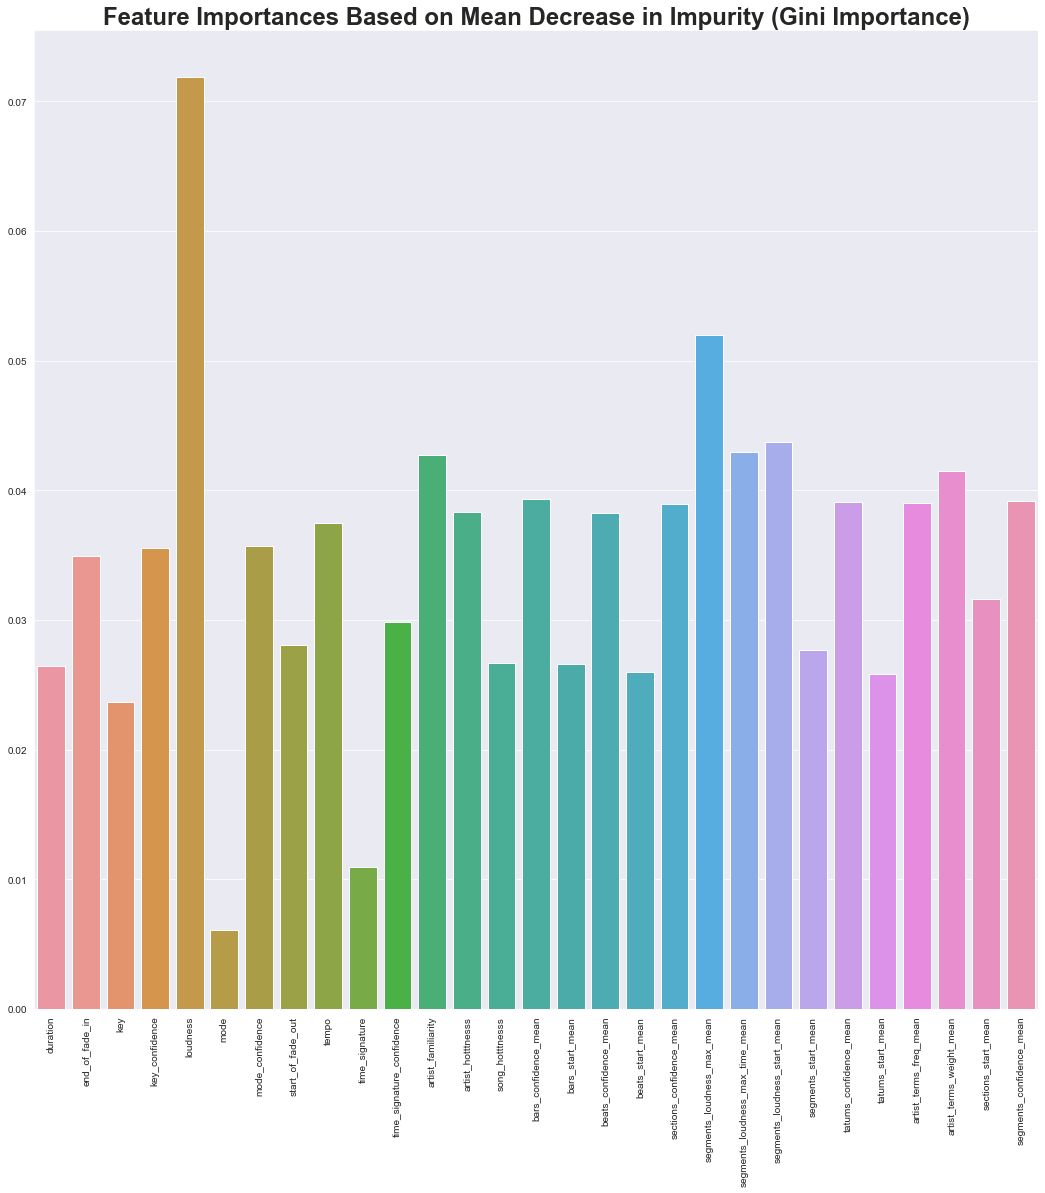

In [224]:
ax = sns.barplot(x = feature_importances.index, y = feature_importances.values)
plt.xticks(rotation = 90)
ax.figure.set_size_inches(18, 18)
plt.title('Feature Importances Based on Mean Decrease in Impurity (Gini Importance)', fontweight = 'bold', fontsize = 24)